### Vérification de la disponibilité du GPU

In [1]:
import torch

# Vérifier si un GPU est disponible
if torch.cuda.is_available():
    print("GPU disponible :", torch.cuda.get_device_name(0))
    print("PyTorch utilise CUDA :", torch.cuda.is_available())
    print("Nombre de GPUs disponibles :", torch.cuda.device_count())
else:
    print("GPU non disponible. PyTorch utilise uniquement le CPU.")

# Optionnel : vérifier le périphérique actuellement utilisé
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Périphérique actif :", device)

GPU disponible : NVIDIA GeForce RTX 2060
PyTorch utilise CUDA : True
Nombre de GPUs disponibles : 1
Périphérique actif : cuda


### Verification de la disponibilité du GPU pour les calculs PyTorch :
PyTorch a été choisi pour ce projet grâce à sa compatibilité native avec CUDA, essentielle pour tirer parti du GPU RTX 2060, et sa flexibilité pour personnaliser des modèles avancés comme **DilatedNet**. Les tests avec Keras 3 en backend PyTorch ont été non concluants, révélant des limitations de performances et une gestion des données complexe. PyTorch offre une meilleure intégration des transformations dynamiques et une efficacité accrue lors de l’entraînement. Grâce à l’exportation ONNX, Franck peut continuer à utiliser Keras pour le traitement des segments, garantissant l’interopérabilité et la fluidité du pipeline. L’API pour Laura reste performante et simple à déployer, respectant les exigences du système global.
   

In [2]:
import torch
import time

# Génération de données aléatoires pour tester
data_size = 10000  # Taille des matrices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Création de deux matrices sur le GPU ou CPU selon la disponibilité
a = torch.rand(data_size, data_size, device=device)
b = torch.rand(data_size, data_size, device=device)

# Vérification que les données sont bien sur le GPU ou CPU
print(f"Device de 'a' : {a.device}")
print(f"Device de 'b' : {b.device}")

# Mesurer le temps de calcul pour une multiplication matricielle
start_time = time.time()
result = torch.mm(a, b)  # Multiplication matricielle
end_time = time.time()

print("Calcul terminé.")
print(f"Durée du calcul : {end_time - start_time:.4f} secondes.")

Device de 'a' : cuda:0
Device de 'b' : cuda:0
Calcul terminé.
Durée du calcul : 0.2029 secondes.


### Entraînement du modèle DilatedNet avec enregistrement des métriques et Data Augmentation

Cette cellule inclut :
- **Architecture :** DilatedNet, basée sur un encodeur ResNet-34 pré-entraîné.
- **Technologies utilisées :** PyTorch, CUDA (si disponible).
- **Fonctionnalités clés :**
  - Utilisation de convolutions dilatées pour extraire des informations contextuelles.
  - Décodeur avec skip connections pour reconstruire la segmentation.
  - Application de **Data Augmentation** (flips horizontaux, rotations, ajustements de luminosité/contraste).
  - Enregistrement des métriques d'entraînement et de validation à chaque époque dans un fichier CSV.


### EDA data
Il y a 2 dossiers :
- **leftImg8bit** : contient les images RGB d'origine
- **gtFine** : contient les masques de la segmentation d'images 

In [3]:
import os
import pandas as pd
from collections import defaultdict

# Chemins des dossiers
leftImg8bit_path = 'data/leftImg8bit/'
gtFine_path = 'data/gtFine/'

# Fonction pour récupérer les statistiques globales du dataset
def analyser_dataset(dossier):
    statistiques = {
        "total_images": 0,
        "total_label_ids": 0,
        "total_autres_fichiers": 0,
        "images_details": [],
        "label_ids_details": []
    }

    for root, dirs, files in os.walk(dossier):
        for file in files:
            extension = os.path.splitext(file)[1].lower()
            file_path = os.path.join(root, file)
            
            if extension == ".png" and "labelIds" in file:
                statistiques["total_label_ids"] += 1
                statistiques["label_ids_details"].append({
                    "Dossier": root,
                    "Fichier": file
                })
            elif extension == ".png":
                statistiques["total_images"] += 1
                statistiques["images_details"].append({
                    "Dossier": root,
                    "Fichier": file
                })
            else:
                statistiques["total_autres_fichiers"] += 1

    return statistiques

# Analyse des deux dossiers
statistiques_leftImg8bit = analyser_dataset(leftImg8bit_path)
statistiques_gtFine = analyser_dataset(gtFine_path)

# Construire les conclusions
conclusions = f"""
JEU DE DONNÉES
Le jeu de données est composé de 2 dossiers:
● leftImg8bit : ce dossier contient les images RGB d’origine. Ce sont les données d’entrée.
    - Nombre total d’images : {statistiques_leftImg8bit['total_images']}
● gtFine : ce dossier contient les masques de segmentation. Ce sont les données de sortie.
    - Nombre total de masques 'labelIds' : {statistiques_gtFine['total_label_ids']}
    - Nombre total d’autres fichiers : {statistiques_gtFine['total_autres_fichiers']}
Les données d’entrée sont des images de 2048 x 1024 pixels sur 3 canaux (RGB).
En ce qui concerne les données de sortie, seuls les fichiers se terminant par '_labelIds.png'
sont intéressants. Ce sont les masques correspondant aux images RGB.

Le dataset est séparé en 3 parties :
● Jeu de test : {len([d for d in statistiques_leftImg8bit['images_details'] if 'test' in d['Dossier']])} images
● Jeu d’entraînement : {len([d for d in statistiques_leftImg8bit['images_details'] if 'train' in d['Dossier']])} images
● Jeu de validation : {len([d for d in statistiques_leftImg8bit['images_details'] if 'val' in d['Dossier']])} images
"""

# Afficher les conclusions
print(conclusions)

# Exporter les détails dans des fichiers CSV pour une analyse approfondie si nécessaire
pd.DataFrame(statistiques_leftImg8bit["images_details"]).to_csv("images_leftImg8bit.csv", index=False)
pd.DataFrame(statistiques_gtFine["label_ids_details"]).to_csv("labelIds_gtFine.csv", index=False)


JEU DE DONNÉES
Le jeu de données est composé de 2 dossiers:
● leftImg8bit : ce dossier contient les images RGB d’origine. Ce sont les données d’entrée.
    - Nombre total d’images : 5000
● gtFine : ce dossier contient les masques de segmentation. Ce sont les données de sortie.
    - Nombre total de masques 'labelIds' : 4628
    - Nombre total d’autres fichiers : 4639
Les données d’entrée sont des images de 2048 x 1024 pixels sur 3 canaux (RGB).
En ce qui concerne les données de sortie, seuls les fichiers se terminant par '_labelIds.png'
sont intéressants. Ce sont les masques correspondant aux images RGB.

Le dataset est séparé en 3 parties :
● Jeu de test : 1525 images
● Jeu d’entraînement : 2975 images
● Jeu de validation : 500 images



### Exemple image RGB d'origine

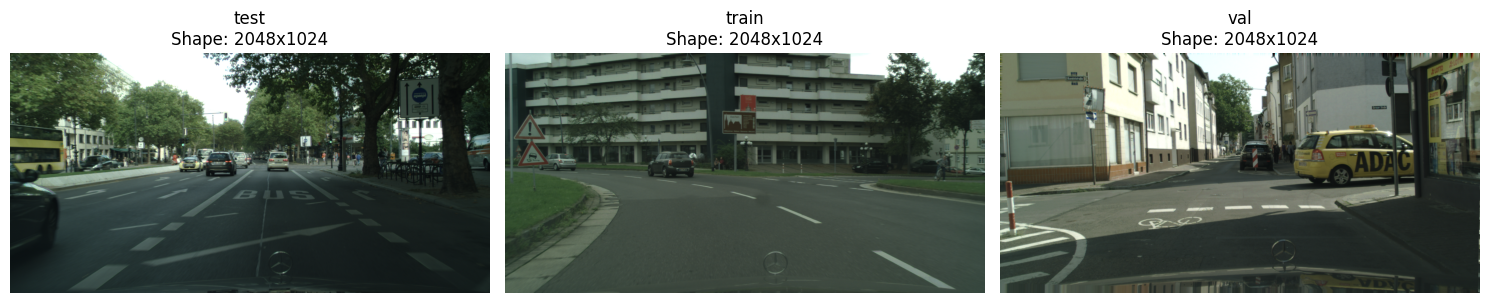

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Chemin vers le dossier leftImg8bit
leftImg8bit_path = 'data/leftImg8bit/'

# Fonction pour afficher des exemples d'images
def afficher_exemples_images(dossier_principal):
    sous_dossiers = ["test", "train", "val"]
    fig, axes = plt.subplots(1, len(sous_dossiers), figsize=(15, 5))

    for i, sous_dossier in enumerate(sous_dossiers):
        dossier = os.path.join(dossier_principal, sous_dossier)
        
        # Trouver une image dans le sous-dossier
        example_image_path = None
        for root, dirs, files in os.walk(dossier):
            for file in files:
                if file.endswith(".png"):  # Vérifier les fichiers PNG
                    example_image_path = os.path.join(root, file)
                    break
            if example_image_path:
                break
        
        if example_image_path:
            # Charger l'image et obtenir sa shape
            image = Image.open(example_image_path)
            axes[i].imshow(image)
            axes[i].axis("off")
            axes[i].set_title(f"{sous_dossier}\nShape: {image.size[0]}x{image.size[1]}")
        else:
            axes[i].set_title(f"{sous_dossier}\nAucune image trouvée")
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Appeler la fonction pour afficher les exemples
afficher_exemples_images(leftImg8bit_path)


### Exemple de masque de segmentation

Associations dans test :
  - Image berlin_000000_000019_gtFine:
    - berlin_000000_000019_gtFine_color.png
    - berlin_000000_000019_gtFine_instanceIds.png
    - berlin_000000_000019_gtFine_labelIds.png
    - berlin_000000_000019_gtFine_polygons.json


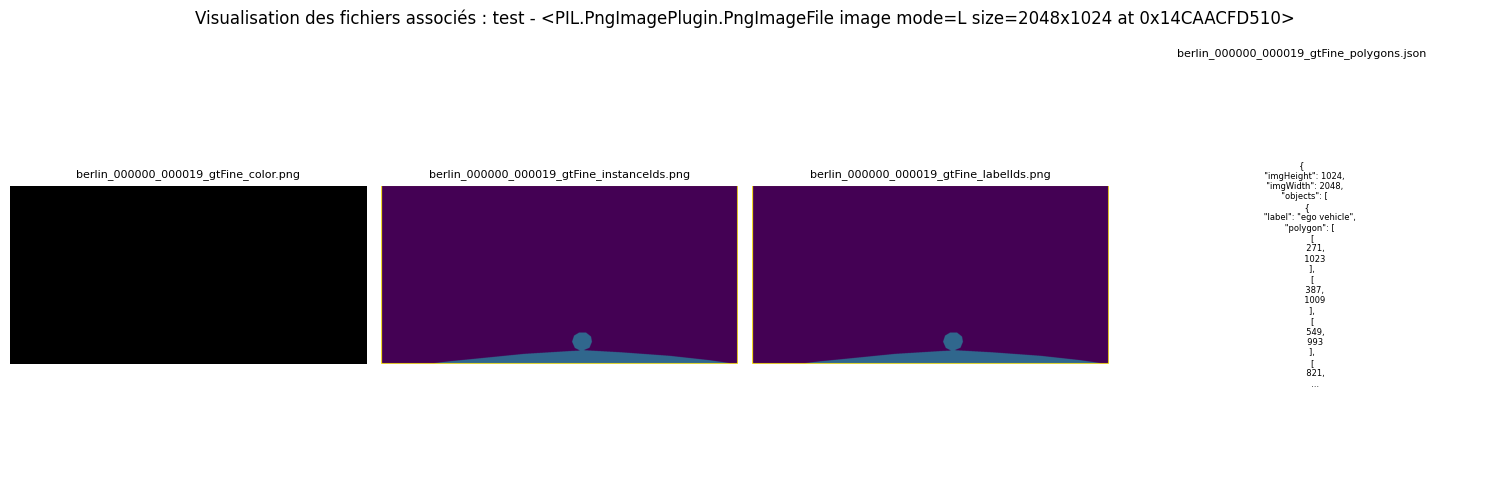

Associations dans train :
  - Image aachen_000000_000019_gtFine:
    - aachen_000000_000019_gtFine_color.png
    - aachen_000000_000019_gtFine_instanceIds.png
    - aachen_000000_000019_gtFine_labelIds.png
    - aachen_000000_000019_gtFine_polygons.json


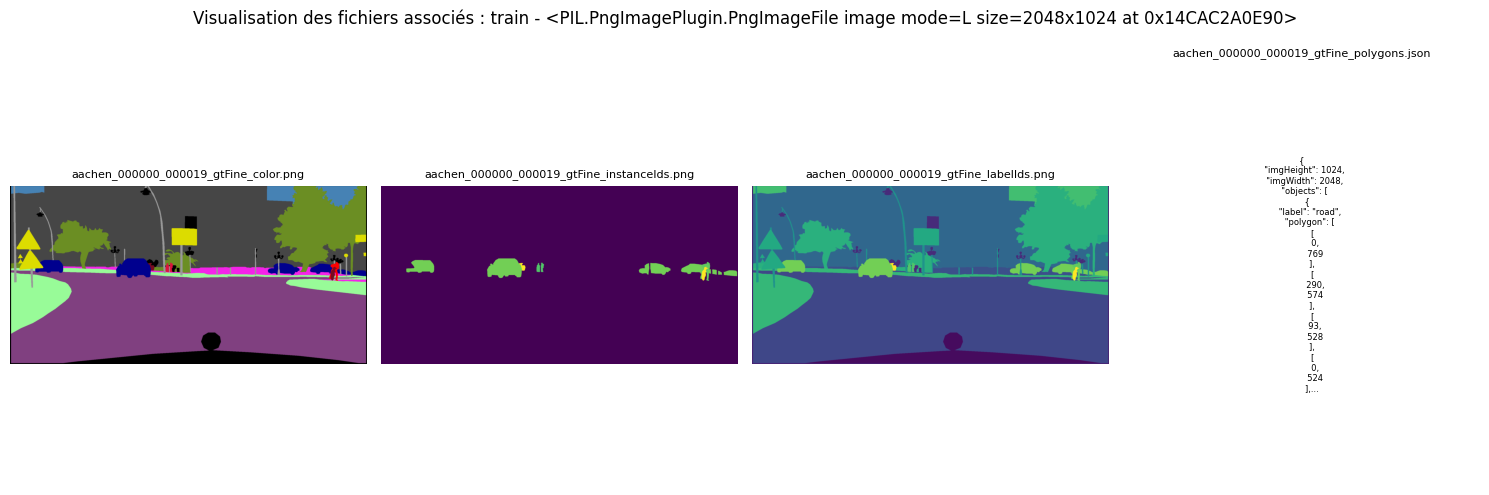

Associations dans val :
  - Image frankfurt_000000_000294_gtFine:
    - frankfurt_000000_000294_gtFine_color.png
    - frankfurt_000000_000294_gtFine_instanceIds.png
    - frankfurt_000000_000294_gtFine_labelIds.png
    - frankfurt_000000_000294_gtFine_polygons.json


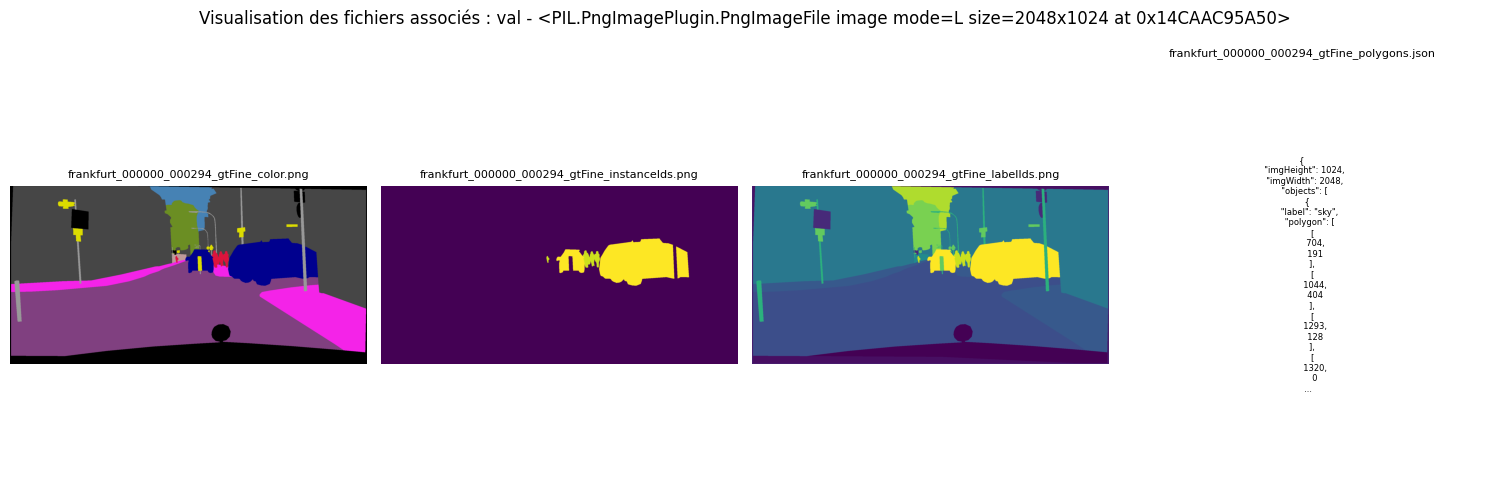

In [5]:
import os
import json
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt

# Chemin vers le dossier gtFine
gtFine_path = 'data/gtFine/'

# Fonction pour analyser les fichiers par image
def analyser_fichiers_et_associations(dossier_principal):
    statistiques = {}

    for sous_dossier in ["test", "train", "val"]:
        chemin_sous_dossier = os.path.join(dossier_principal, sous_dossier)
        fichiers_par_image = defaultdict(list)
        types_de_fichiers = defaultdict(int)

        # Parcourir les fichiers du sous-dossier
        for root, dirs, files in os.walk(chemin_sous_dossier):
            for file in files:
                extension = os.path.splitext(file)[1].lower()
                base_name = "_".join(file.split("_")[:-1])  # Identifier le groupe d'une image (numérotation)
                fichiers_par_image[base_name].append(os.path.join(root, file))
                types_de_fichiers[extension] += 1

        statistiques[sous_dossier] = {
            "types_de_fichiers": dict(types_de_fichiers),
            "fichiers_par_image": dict(fichiers_par_image)
        }

    return statistiques

# Fonction pour afficher et visualiser les fichiers associés
def afficher_exemples_et_visualisations(statistiques):
    for sous_dossier, data in statistiques.items():
        fichiers_par_image = data["fichiers_par_image"]

        print(f"Associations dans {sous_dossier} :")
        
        # Limité à 1 image pour visualisation complète dans chaque sous-dossier
        for image, fichiers in list(fichiers_par_image.items())[:1]:
            print(f"  - Image {image}:")
            for fichier in fichiers:
                print(f"    - {os.path.basename(fichier)}")

            # Visualiser les fichiers associés
            fig, axes = plt.subplots(1, len(fichiers), figsize=(15, 5))
            for idx, fichier in enumerate(fichiers):
                if fichier.endswith(".png"):  # Afficher les images PNG
                    image = Image.open(fichier)
                    axes[idx].imshow(image)
                    axes[idx].axis("off")
                    axes[idx].set_title(os.path.basename(fichier), fontsize=8)
                elif fichier.endswith(".json"):  # Lire et afficher un extrait du JSON
                    with open(fichier, 'r') as f:
                        json_content = json.load(f)
                        extrait = json.dumps(json_content, indent=2)[:300] + "..."
                    axes[idx].text(0.5, 0.5, extrait, fontsize=6, wrap=True, ha='center', va='center')
                    axes[idx].axis("off")
                    axes[idx].set_title(os.path.basename(fichier), fontsize=8)
                else:
                    axes[idx].axis("off")
                    axes[idx].set_title(f"{os.path.basename(fichier)}\n(non visualisable)", fontsize=8)

            plt.suptitle(f"Visualisation des fichiers associés : {sous_dossier} - {image}")
            plt.tight_layout()
            plt.show()

# Analyser les fichiers et visualiser
statistiques_gtFine = analyser_fichiers_et_associations(gtFine_path)
afficher_exemples_et_visualisations(statistiques_gtFine)

### Analyse des données et utilisation des fichiers

#### Données d'entrée : `leftImg8bit_path`
- Les données d’entrée sont situées dans le dossier `leftImg8bit`.
- Ce dossier contient les **images RGB originales**, qui sont les données d’entrée pour l’entraînement du modèle.
- **Caractéristiques des images d’entrée** :
  - Résolution : **2048 x 1024 pixels**.
  - Canaux : **3 canaux (RGB)**.
- Ces images représentent l'environnement que le modèle doit analyser et segmenter.

---

### Données de sortie : `gtFine_path`
- Les données de sortie sont situées dans le dossier `gtFine`.
- Ce dossier contient plusieurs types de fichiers, mais nous nous intéressons uniquement aux fichiers dont le nom se termine par `*_labelIds.png`.

#### Fichiers `*_labelIds.png` :
- Ce sont les **masques d'annotation** pour la segmentation.
- Chaque pixel du masque a une valeur correspondant à l'**identifiant d'une classe** (par exemple, route, voiture, trottoir, etc.).
- **Caractéristiques des fichiers `*_labelIds.png`** :
  - Les valeurs des pixels indiquent les identifiants des labels de segmentation.
  - Il existe **32 catégories différentes** à mapper vers **8 catégories principales** pour simplifier le problème.

#### Autres fichiers dans `gtFine` :
Bien que nous ne les utilisions pas dans ce cas précis, voici les autres types de fichiers présents :
- **`*_polygons.json`** :
  - Contiennent des métadonnées descriptives pour chaque objet (par exemple, catégories et polygones de segmentation).
- **`*_color.png`** :
  - Représentations visuelles des masques, où chaque classe est représentée par une couleur unique.
- **`*_instanceIds.png`** :
  - Identifiants uniques pour chaque instance d'objet dans les images (utile pour la segmentation d'instances).

---

### Structure du dataset

- Le dataset est séparé en **3 parties** :
  1. **Jeu de test** : **1525 images**.
  2. **Jeu d’entraînement** : **2975 images**.
  3. **Jeu de validation** : **500 images**.

Chaque partie est organisée de la manière suivante :
- Les images d’entrée sont situées dans le dossier `leftImg8bit/test`, `leftImg8bit/train`, ou `leftImg8bit/val`.
- Les masques d’annotation (données de sortie) sont situés dans `gtFine/test`, `gtFine/train`, ou `gtFine/val`.

---

## Résumé

| Type de données          | Chemin                | Description                                                                            |
|--------------------------|-----------------------|----------------------------------------------------------------------------------------|
| **Images d’entrée**      | `leftImg8bit_path`   | Images RGB (2048 x 1024, 3 canaux).                                                   |
| **Masques d’annotation** | `gtFine_path`        | Fichiers `*_labelIds.png` : identifiants des labels pour chaque pixel.                |
| **Jeu de test**          | `test`              | Contient 1525 images et leurs masques associés.                                       |
| **Jeu d’entraînement**   | `train`             | Contient 2975 images et leurs masques associés.                                       |
| **Jeu de validation**    | `val`               | Contient 500 images et leurs masques associés.                                        |

---

### Utilisation pour l'entraînement

- **Données d’entrée** : Les images RGB du dossier `leftImg8bit`.
- **Données de sortie** : Les masques `*_labelIds.png` du dossier `gtFine`.

Ces deux ensembles de données permettront d'entraîner un modèle de segmentation capable d'identifier et de classer chaque pixel dans l'image en fonction des 8 catégories principales définies.



### Fichiers dans le train

In [6]:
import os

train_path = 'data/gtFine/train/'
print("Fichiers disponibles dans le dossier train :")
print(os.listdir(train_path))


Fichiers disponibles dans le dossier train :
['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']


### Exemple de masque de segmentation et de comment fonctionne la segmentation par pixel

Shape du masque : (1024, 2048)
Valeurs uniques dans le masque : [ 0  1  3  4  7  8 11 17 20 21 22 23 24 25 26 33]
Portion du masque (200x250) :
 [[7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 ...
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]]


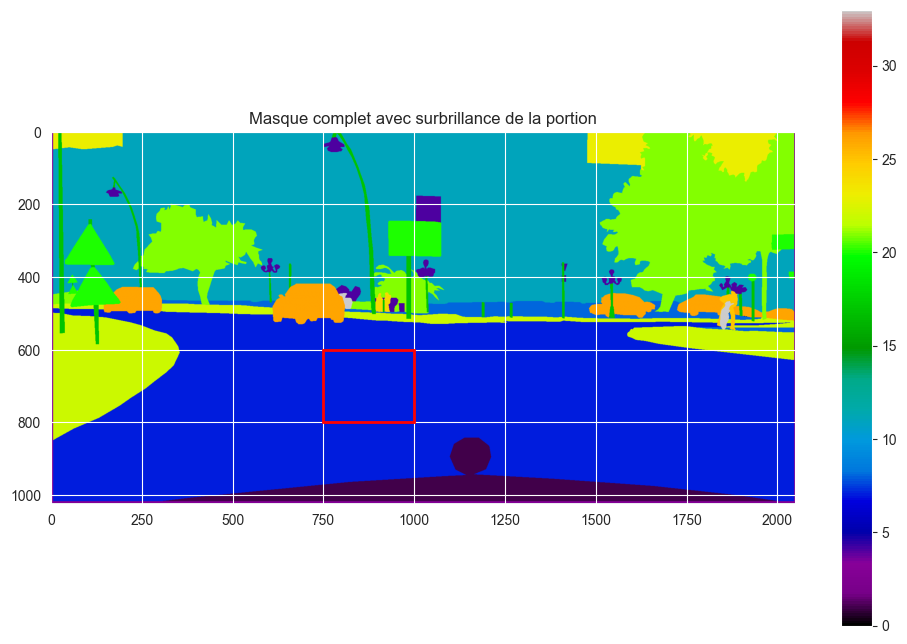

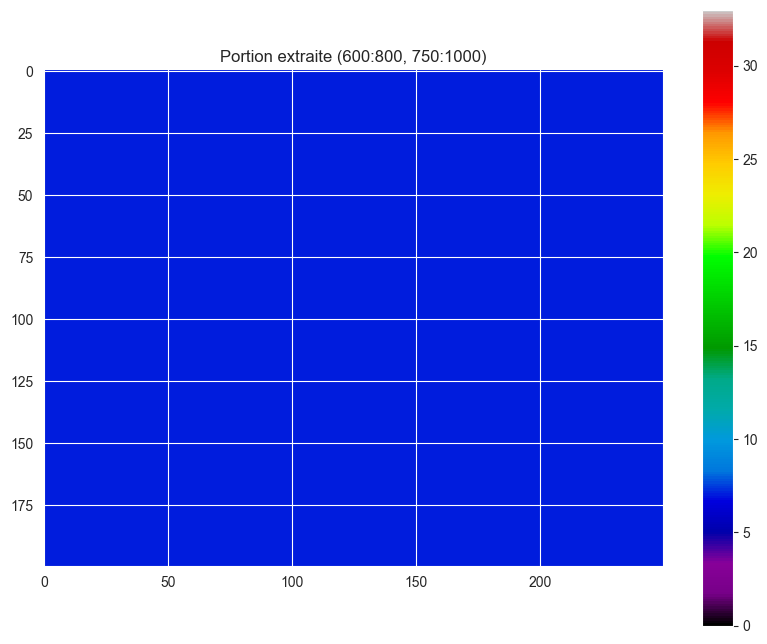

In [31]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Chemin vers le dossier gtFine
gtFine_path = 'data/gtFine/'  # Dossier principal
image_subfolder = 'train/aachen'  # Sous-dossier
image_name = 'aachen_000000_000019_gtFine_labelIds.png'  # Nom exact de l'image

# Construire le chemin complet vers l'image
image_path = f"{gtFine_path}{image_subfolder}/{image_name}"

# Charger l'image
mask = np.array(Image.open(image_path))  # Convertir l'image en une matrice numpy

# Afficher la taille de l'image
print("Shape du masque :", mask.shape)

# Afficher les valeurs uniques dans le masque (identifiants des classes présentes)
print("Valeurs uniques dans le masque :", np.unique(mask))

# Définir la portion du masque à visualiser
start_row, end_row = 600, 800  # Ordonnées sélectionnées
start_col, end_col = 750, 1000  # Abscisses sélectionnées
portion = mask[start_row:end_row, start_col:end_col]

# Afficher la portion extraite
print(f"Portion du masque ({end_row-start_row}x{end_col-start_col}) :\n", portion)

# Définir les limites de la palette (valeurs minimales et maximales de l'image complète)
vmin, vmax = mask.min(), mask.max()

# Visualiser le masque complet avec surbrillance de la portion
plt.figure(figsize=(12, 8))
plt.imshow(mask, cmap="nipy_spectral", vmin=vmin, vmax=vmax)  # Applique une palette fixe
plt.colorbar()
plt.title("Masque complet avec surbrillance de la portion")

# Ajouter un rectangle pour la portion sélectionnée
plt.gca().add_patch(plt.Rectangle((start_col, start_row), end_col-start_col, end_row-start_row, 
                                   edgecolor='red', facecolor='none', lw=2))  # Rectangle rouge
plt.show()

# Visualiser uniquement la portion extraite avec la même palette
plt.figure(figsize=(10, 8))
plt.imshow(portion, cmap="nipy_spectral", vmin=vmin, vmax=vmax)  # Applique la même échelle que l'image complète
plt.colorbar()
plt.title(f"Portion extraite ({start_row}:{end_row}, {start_col}:{end_col})")
plt.show()


#### Observations

#### Shape du masque
- La résolution de l'image est **(1024, 2048)**.
- Chaque pixel du masque correspond à une valeur unique représentant une **classe d'objets** dans l'image.

---

#### Valeurs uniques dans le masque
- Les valeurs uniques dans le masque correspondent aux **identifiants des classes** de segmentation.
- Ces valeurs permettent d'assigner une catégorie à chaque pixel, comme "route", "ciel", "bâtiment", etc.

Dans cette image, les valeurs observées sont :
- `7` : **Route** (Classe `Road`).
- `21` : **Végétation** (Classe `Vegetation`).
- `23` : **Ciel** (Classe `Sky`).
- `3` : **Mur/Bâtiment** (Classe `Building/Wall`).

---

#### Interprétation visuelle
L'image ci-dessus affiche le masque à l'aide d'une palette de couleurs distinctes. Voici les principales observations :

1. **Masque complet :**
   - La portion encadrée en **rouge** correspond à une zone où la route est bien visible.
   - Les zones environnantes incluent de la **végétation**, du **ciel**, et d'autres objets.

2. **Portion extraite :**
   - La portion (délimitée par les coordonnées 600:800 en ordonnée et 750:1000 en abscisse) contient exclusivement la classe **Route**.
   - Cela se reflète par la valeur `7` sur tous les pixels de la portion extraite.

---

#### Comparaison entre masque complet et portion extraite
- Dans le **masque complet**, la palette de couleurs permet de distinguer toutes les classes (par exemple, ciel, végétation, route).
- Dans la **portion extraite**, la valeur `7` est prédominante, correspondant uniquement à la classe "Route".
- La cohérence des couleurs entre le masque complet et la portion est assurée grâce à une échelle fixe (`vmin` et `vmax`).

#### **Correspondance des classes de segmentation**
- Ces informations sont tirées de la documentation officielle de Cityscapes. Les identifiants sont utilisés dans les fichiers `*_labelIds.png` pour représenter les classes de segmentation.

| **Classe (EN)**       | **Classe (FR)**       | **ID** | **TrainID** | **Catégorie**     | **CatID** | **HasInstances** | **IgnoreInEval** | **Couleur (RGB)** | **Couleur (description)**      |
|------------------------|-----------------------|--------|-------------|-------------------|-----------|------------------|------------------|-------------------|--------------------------------|
| unlabeled             | Non étiqueté         | 0      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| ego vehicle           | Véhicule propre      | 1      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| rectification border  | Bord rectifié        | 2      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| out of roi            | Hors région d'intérêt| 3      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| static                | Statique            | 4      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| dynamic               | Dynamique           | 5      | 255         | void              | 0         | False            | True             | (111, 74, 0)      | Marron foncé                   |
| ground                | Sol                 | 6      | 255         | void              | 0         | False            | True             | (81, 0, 81)       | Violet foncé                   |
| road                  | Route               | 7      | 0           | flat              | 1         | False            | False            | (128, 64, 128)    | Violet                         |
| sidewalk              | Trottoir            | 8      | 1           | flat              | 1         | False            | False            | (244, 35, 232)    | Rose                           |
| parking               | Parking             | 9      | 255         | flat              | 1         | False            | True             | (250, 170, 160)   | Rose pâle                      |
| rail track            | Rail                | 10     | 255         | flat              | 1         | False            | True             | (230, 150, 140)   | Rouge clair                    |
| building              | Bâtiment            | 11     | 2           | construction      | 2         | False            | False            | (70, 70, 70)      | Gris                           |
| wall                  | Mur                 | 12     | 3           | construction      | 2         | False            | False            | (102, 102, 156)   | Gris-bleu                      |
| fence                 | Clôture             | 13     | 4           | construction      | 2         | False            | False            | (190, 153, 153)   | Gris clair                     |
| guard rail            | Garde-corps         | 14     | 255         | construction      | 2         | False            | True             | (180, 165, 180)   | Mauve                          |
| bridge                | Pont                | 15     | 255         | construction      | 2         | False            | True             | (150, 100, 100)   | Marron                         |
| tunnel                | Tunnel              | 16     | 255         | construction      | 2         | False            | True             | (150, 120, 90)    | Beige                          |
| pole                  | Poteau              | 17     | 5           | object            | 3         | False            | False            | (153, 153, 153)   | Gris clair                     |
| polegroup             | Groupe de poteaux   | 18     | 255         | object            | 3         | False            | True             | (153, 153, 153)   | Gris clair                     |
| traffic light         | Feu de signalisation| 19     | 6           | object            | 3         | False            | False            | (250, 170, 30)    | Orange                         |
| traffic sign          | Panneau de signal.  | 20     | 7           | object            | 3         | False            | False            | (220, 220, 0)     | Jaune                          |
| vegetation            | Végétation          | 21     | 8           | nature            | 4         | False            | False            | (107, 142, 35)    | Vert foncé                     |
| terrain               | Terrain             | 22     | 9           | nature            | 4         | False            | False            | (152, 251, 152)   | Vert clair                     |
| sky                   | Ciel                | 23     | 10          | sky               | 5         | False            | False            | (70, 130, 180)    | Bleu ciel                      |
| person                | Personne            | 24     | 11          | human             | 6         | True             | False            | (220, 20, 60)     | Rouge                          |
| rider                 | Cycliste/Motard     | 25     | 12          | human             | 6         | True             | False            | (255, 0, 0)       | Rouge vif                      |
| car                   | Voiture             | 26     | 13          | vehicle           | 7         | True             | False            | (0, 0, 142)       | Bleu foncé                     |
| truck                 | Camion              | 27     | 14          | vehicle           | 7         | True             | False            | (0, 0, 70)        | Bleu très foncé                |
| bus                   | Bus                 | 28     | 15          | vehicle           | 7         | True             | False            | (0, 60, 100)      | Bleu-vert foncé                |
| caravan               | Caravane            | 29     | 255         | vehicle           | 7         | True             | True             | (0, 0, 90)        | Bleu nuit                      |
| trailer               | Remorque            | 30     | 255         | vehicle           | 7         | True             | True             | (0, 0, 110)       | Bleu acier                     |
| train                 | Train               | 31     | 16          | vehicle           | 7         | True             | False            | (0, 80, 100)      | Turquoise foncé                |
| motorcycle            | Moto                | 32     | 17          | vehicle           | 7         | True             | False            | (0, 0, 230)       | Bleu vif                       |
| bicycle               | Vélo                | 33     | 18          | vehicle           | 7         | True             | False            | (119, 11, 32)     | Rouge sombre                   |
| license plate         | Plaque d'immatric. | -1     | -1          | vehicle           | 7         | False            | True             | (0, 0, 142)       | Bleu foncé                     |

---

#### **Regroupement en 8 catégories principales**

```python
cats = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

###  1.Entraînement du modèle DilatedNet avec enregistrement des métriques et Data Augmentation

Cette cellule inclut :
- **Architecture :** DilatedNet, basée sur un encodeur ResNet-34 pré-entraîné.
- **Technologies utilisées :** PyTorch, CUDA (si disponible).
- **Fonctionnalités clés :**
  - Utilisation de convolutions dilatées pour extraire des informations contextuelles.
  - Décodeur avec skip connections pour reconstruire la segmentation.
  - Application de **Data Augmentation** (flips horizontaux, rotations, ajustements de luminosité/contraste).
  - Enregistrement des métriques d'entraînement et de validation à chaque époque dans un fichier CSV.

In [32]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
from PIL import Image
from tqdm import tqdm
import pandas as pd
import torch.nn.functional as F
from torchvision.transforms import functional as TF

# Détection du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Définition des chemins
base_dir = os.path.join(os.getcwd(), 'data')
train_image_dir = os.path.join(base_dir, 'leftImg8bit', 'train')
train_mask_dir = os.path.join(base_dir, 'gtFine', 'train')
val_image_dir = os.path.join(base_dir, 'leftImg8bit', 'val')
val_mask_dir = os.path.join(base_dir, 'gtFine', 'val')

model_save_path = os.path.join(os.getcwd(), "models", "segmentation_model.pth")
metrics_file_path = os.path.join(base_dir, "metrics_dilatednet.csv")

# Mapping des catégories
cats = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}
category_mapping = {subclass: idx for idx, (cat, subclasses) in enumerate(cats.items()) for subclass in subclasses}

# Transformations et augmentations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


class Augmentations:
    def __call__(self, image, mask):
        if torch.rand(1).item() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        angle = torch.randint(-10, 10, (1,)).item()
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)
        color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
        image = color_jitter(image)
        return image, mask


class CityscapesDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, augmentations=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.augmentations = augmentations
        self.images = []
        self.masks = []

        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".png"):
                    image_path = os.path.join(root, file)
                    mask_path = os.path.join(mask_dir, root.split(os.sep)[-1],
                                             file.replace("_leftImg8bit.png", "_gtFine_labelIds.png"))
                    if os.path.exists(mask_path):
                        self.images.append(image_path)
                        self.masks.append(mask_path)

        print(f"Nombre d'images trouvées : {len(self.images)}")
        print(f"Nombre de masques trouvés : {len(self.masks)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx])
        if self.augmentations:
            image, mask = self.augmentations(image, mask)
        if self.transform:
            image = self.transform(image)
            mask = mask.resize((256, 256))
            mask = np.array(mask)
            mapped_mask = np.zeros_like(mask, dtype=np.long)
            for val, cat_idx in category_mapping.items():
                mapped_mask[mask == val] = cat_idx
            mask = torch.tensor(mapped_mask, dtype=torch.long)
        return image, mask


augmentations = Augmentations()
train_dataset = CityscapesDataset(
    image_dir=train_image_dir,
    mask_dir=train_mask_dir,
    transform=transform,
    augmentations=augmentations
)
val_dataset = CityscapesDataset(
    image_dir=val_image_dir,
    mask_dir=val_mask_dir,
    transform=transform,
    augmentations=None
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


class DilatedNet(nn.Module):
    def __init__(self, num_classes):
        super(DilatedNet, self).__init__()
        self.encoder = models.resnet34(weights='IMAGENET1K_V1')
        self.encoder_layers = list(self.encoder.children())[:-2]
        self.enc1 = nn.Sequential(*self.encoder_layers[:3])
        self.enc2 = nn.Sequential(*self.encoder_layers[3:5])
        self.enc3 = nn.Sequential(*self.encoder_layers[5])
        self.enc4 = nn.Sequential(*self.encoder_layers[6])
        self.enc5 = nn.Sequential(*self.encoder_layers[7])
        self.dilated1 = nn.Conv2d(512, 256, kernel_size=3, dilation=2, padding=2)
        self.dilated2 = nn.Conv2d(256, 256, kernel_size=3, dilation=4, padding=4)
        self.dec4 = self._decoder_block(256 + 256, 128)
        self.dec3 = self._decoder_block(128 + 128, 64)
        self.dec2 = self._decoder_block(64 + 64, 64)
        self.dec1 = self._decoder_block(64, 64)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        dilated = self.dilated1(enc5)
        dilated = self.dilated2(dilated)
        enc4_resized = F.interpolate(enc4, size=dilated.shape[2:], mode="bilinear", align_corners=False)
        dec4 = self.dec4(torch.cat([dilated, enc4_resized], dim=1))
        enc3_resized = F.interpolate(enc3, size=dec4.shape[2:], mode="bilinear", align_corners=False)
        dec3 = self.dec3(torch.cat([dec4, enc3_resized], dim=1))
        enc2_resized = F.interpolate(enc2, size=dec3.shape[2:], mode="bilinear", align_corners=False)
        dec2 = self.dec2(torch.cat([dec3, enc2_resized], dim=1))
        enc1_resized = F.interpolate(enc1, size=dec2.shape[2:], mode="bilinear", align_corners=False)
        dec1 = self.dec1(enc1_resized)
        final_output = self.final(dec1)
        final_output_resized = F.interpolate(final_output, size=(256, 256), mode="bilinear", align_corners=False)
        return final_output_resized


def calculate_iou(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    iou = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            iou.append(float('nan'))
        else:
            iou.append(intersection / union)
    return np.nanmean(iou)


def calculate_dice(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    dice = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        dice_score = (2 * intersection) / (pred_inds.sum().item() + target_inds.sum().item() + 1e-7)
        dice.append(dice_score)
    return np.mean(dice)

def train_model_with_early_stopping(model, dataloaders, optimizer, criterion, num_epochs, patience, metrics_file):
    model = model.to(device)
    best_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    metrics_df = pd.DataFrame(columns=["epoch", "train_loss", "val_loss", "iou", "dice"])

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        train_dice = 0.0
        num_batches = 0

        for images, masks in tqdm(dataloaders["train"]):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate metrics
            train_iou += calculate_iou(outputs, masks, num_classes)
            train_dice += calculate_dice(outputs, masks, num_classes)
            num_batches += 1

        train_loss /= num_batches
        train_iou /= num_batches
        train_dice /= num_batches

        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        val_dice = 0.0
        num_val_batches = 0

        with torch.no_grad():
            for images, masks in dataloaders["val"]:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()

                # Calculate metrics
                val_iou += calculate_iou(outputs, masks, num_classes)
                val_dice += calculate_dice(outputs, masks, num_classes)
                num_val_batches += 1

        val_loss /= num_val_batches
        val_iou /= num_val_batches
        val_dice /= num_val_batches

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}")

        new_row = pd.DataFrame({
            "epoch": [epoch + 1],
            "train_loss": [train_loss],
            "val_loss": [val_loss],
            "iou": [val_iou],
            "dice": [val_dice]
        })
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = model.state_dict()
            patience_counter = 0
            print("Validation loss improved, saving the model...")
            torch.save(best_model_weights, model_save_path)
        else:
            patience_counter += 1
            print(f"Early stopping patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    metrics_df.to_csv(metrics_file, index=False)
    print(f"Métriques sauvegardées dans {metrics_file}")

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return model


num_classes = 8
model = DilatedNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dataloaders = {"train": train_loader, "val": val_loader}

num_epochs = 25  # Adjusted to 25 epochs as requested
patience = 3


model = train_model_with_early_stopping(
    model,
    dataloaders,
    optimizer,
    criterion,
    num_epochs=num_epochs,
    patience=patience,
    metrics_file=metrics_file_path
)

print(f"Model saved at {model_save_path}")

Using device: cuda
Nombre d'images trouvées : 2975
Nombre de masques trouvés : 2975
Nombre d'images trouvées : 500
Nombre de masques trouvés : 500
Epoch 1/25


100%|██████████| 186/186 [07:10<00:00,  2.32s/it]
C:\Users\pat\AppData\Local\Temp\ipykernel_5536\1659697234.py:258: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


Train Loss: 1.1254, Val Loss: 0.9718, IoU: 0.3087, Dice: 0.4148
Validation loss improved, saving the model...
Epoch 2/25


100%|██████████| 186/186 [07:02<00:00,  2.27s/it]


Train Loss: 0.9216, Val Loss: 0.9078, IoU: 0.3376, Dice: 0.4486
Validation loss improved, saving the model...
Epoch 3/25


100%|██████████| 186/186 [07:03<00:00,  2.28s/it]


Train Loss: 0.8785, Val Loss: 0.9112, IoU: 0.3369, Dice: 0.4479
Early stopping patience counter: 1/3
Epoch 4/25


100%|██████████| 186/186 [06:59<00:00,  2.26s/it]


Train Loss: 0.8556, Val Loss: 0.8949, IoU: 0.3496, Dice: 0.4616
Validation loss improved, saving the model...
Epoch 5/25


100%|██████████| 186/186 [07:31<00:00,  2.43s/it]


Train Loss: 0.8326, Val Loss: 1.0442, IoU: 0.3202, Dice: 0.4373
Early stopping patience counter: 1/3
Epoch 6/25


100%|██████████| 186/186 [07:31<00:00,  2.43s/it]


Train Loss: 0.8199, Val Loss: 0.8681, IoU: 0.3500, Dice: 0.4621
Validation loss improved, saving the model...
Epoch 7/25


100%|██████████| 186/186 [07:42<00:00,  2.49s/it]


Train Loss: 0.8110, Val Loss: 0.8636, IoU: 0.3565, Dice: 0.4698
Validation loss improved, saving the model...
Epoch 8/25


100%|██████████| 186/186 [07:42<00:00,  2.49s/it]


Train Loss: 0.8017, Val Loss: 0.8420, IoU: 0.3645, Dice: 0.4773
Validation loss improved, saving the model...
Epoch 9/25


100%|██████████| 186/186 [07:50<00:00,  2.53s/it]


Train Loss: 0.7979, Val Loss: 0.8510, IoU: 0.3631, Dice: 0.4758
Early stopping patience counter: 1/3
Epoch 10/25


100%|██████████| 186/186 [08:07<00:00,  2.62s/it]


Train Loss: 0.7895, Val Loss: 0.8338, IoU: 0.3693, Dice: 0.4811
Validation loss improved, saving the model...
Epoch 11/25


100%|██████████| 186/186 [07:19<00:00,  2.36s/it]


Train Loss: 0.7822, Val Loss: 0.8530, IoU: 0.3656, Dice: 0.4779
Early stopping patience counter: 1/3
Epoch 12/25


100%|██████████| 186/186 [07:05<00:00,  2.29s/it]


Train Loss: 0.7783, Val Loss: 0.8385, IoU: 0.3632, Dice: 0.4763
Early stopping patience counter: 2/3
Epoch 13/25


100%|██████████| 186/186 [06:46<00:00,  2.18s/it]


Train Loss: 0.7713, Val Loss: 0.8297, IoU: 0.3616, Dice: 0.4710
Validation loss improved, saving the model...
Epoch 14/25


100%|██████████| 186/186 [06:42<00:00,  2.16s/it]


Train Loss: 0.7682, Val Loss: 0.8230, IoU: 0.3764, Dice: 0.4882
Validation loss improved, saving the model...
Epoch 15/25


100%|██████████| 186/186 [06:41<00:00,  2.16s/it]


Train Loss: 0.7627, Val Loss: 0.8557, IoU: 0.3726, Dice: 0.4854
Early stopping patience counter: 1/3
Epoch 16/25


100%|██████████| 186/186 [06:43<00:00,  2.17s/it]


Train Loss: 0.7652, Val Loss: 0.9052, IoU: 0.3696, Dice: 0.4891
Early stopping patience counter: 2/3
Epoch 17/25


100%|██████████| 186/186 [06:54<00:00,  2.23s/it]


Train Loss: 0.7617, Val Loss: 0.8217, IoU: 0.3780, Dice: 0.4919
Validation loss improved, saving the model...
Epoch 18/25


100%|██████████| 186/186 [06:57<00:00,  2.24s/it]


Train Loss: 0.7565, Val Loss: 0.8203, IoU: 0.3770, Dice: 0.4899
Validation loss improved, saving the model...
Epoch 19/25


100%|██████████| 186/186 [06:56<00:00,  2.24s/it]


Train Loss: 0.7520, Val Loss: 0.8074, IoU: 0.3870, Dice: 0.5009
Validation loss improved, saving the model...
Epoch 20/25


100%|██████████| 186/186 [06:56<00:00,  2.24s/it]


Train Loss: 0.7495, Val Loss: 0.8057, IoU: 0.3886, Dice: 0.5027
Validation loss improved, saving the model...
Epoch 21/25


100%|██████████| 186/186 [06:57<00:00,  2.25s/it]


Train Loss: 0.7465, Val Loss: 0.7908, IoU: 0.3926, Dice: 0.5061
Validation loss improved, saving the model...
Epoch 22/25


100%|██████████| 186/186 [07:07<00:00,  2.30s/it]


Train Loss: 0.7459, Val Loss: 0.8165, IoU: 0.3862, Dice: 0.4988
Early stopping patience counter: 1/3
Epoch 23/25


100%|██████████| 186/186 [06:58<00:00,  2.25s/it]


Train Loss: 0.7423, Val Loss: 0.8023, IoU: 0.3880, Dice: 0.4996
Early stopping patience counter: 2/3
Epoch 24/25


100%|██████████| 186/186 [06:59<00:00,  2.26s/it]


Train Loss: 0.7409, Val Loss: 0.7990, IoU: 0.3907, Dice: 0.5027
Early stopping patience counter: 3/3
Early stopping triggered.
Métriques sauvegardées dans D:\OC_IA\P8\OC_IA_P8_VoitureAutonome\data\metrics_dilatednet.csv
Model saved at D:\OC_IA\P8\OC_IA_P8_VoitureAutonome\models\segmentation_model.pth


### Sauvegarde du modèle complet pour une utilisation future (inference)

In [16]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Recréer l'architecture du modèle
class DilatedNet(nn.Module):
    def __init__(self, num_classes):
        super(DilatedNet, self).__init__()
        self.encoder = models.resnet34(weights='IMAGENET1K_V1')
        self.encoder_layers = list(self.encoder.children())[:-2]
        self.enc1 = nn.Sequential(*self.encoder_layers[:3])
        self.enc2 = nn.Sequential(*self.encoder_layers[3:5])
        self.enc3 = nn.Sequential(*self.encoder_layers[5])
        self.enc4 = nn.Sequential(*self.encoder_layers[6])
        self.enc5 = nn.Sequential(*self.encoder_layers[7])
        self.dilated1 = nn.Conv2d(512, 256, kernel_size=3, dilation=2, padding=2)
        self.dilated2 = nn.Conv2d(256, 256, kernel_size=3, dilation=4, padding=4)
        self.dec4 = self._decoder_block(256 + 256, 128)
        self.dec3 = self._decoder_block(128 + 128, 64)
        self.dec2 = self._decoder_block(64 + 64, 64)
        self.dec1 = self._decoder_block(64, 64)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        dilated = self.dilated1(enc5)
        dilated = self.dilated2(dilated)
        enc4_resized = F.interpolate(enc4, size=dilated.shape[2:], mode="bilinear", align_corners=False)
        dec4 = self.dec4(torch.cat([dilated, enc4_resized], dim=1))
        enc3_resized = F.interpolate(enc3, size=dec4.shape[2:], mode="bilinear", align_corners=False)
        dec3 = self.dec3(torch.cat([dec4, enc3_resized], dim=1))
        enc2_resized = F.interpolate(enc2, size=dec3.shape[2:], mode="bilinear", align_corners=False)
        dec2 = self.dec2(torch.cat([dec3, enc2_resized], dim=1))
        enc1_resized = F.interpolate(enc1, size=dec2.shape[2:], mode="bilinear", align_corners=False)
        dec1 = self.dec1(enc1_resized)
        final_output = self.final(dec1)
        final_output_resized = F.interpolate(final_output, size=(256, 256), mode="bilinear", align_corners=False)
        return final_output_resized

# Détection du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Définir le nombre de classes
num_classes = 8

# Charger l'architecture du modèle
model = DilatedNet(num_classes=num_classes).to(device)

# Charger les poids enregistrés
weights_path = os.path.join(os.getcwd(), "models", "segmentation_model.pth")
model.load_state_dict(torch.load(weights_path, map_location=device))

# Sauvegarder le modèle complet
complete_model_save_path = os.path.join(os.getcwd(), "models", "dilatednet_complete_model.pth")
torch.save(model, complete_model_save_path)
print(f"Modèle complet sauvegardé dans {complete_model_save_path}")


Using device: cuda


C:\Users\pat\AppData\Local\Temp\ipykernel_19628\2707277776.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=d

Modèle complet sauvegardé dans D:\OC_IA\P8\OC_IA_P8_VoitureAutonome\models\dilatednet_complete_model.pth


### Visualisation des métriques d'entraînement

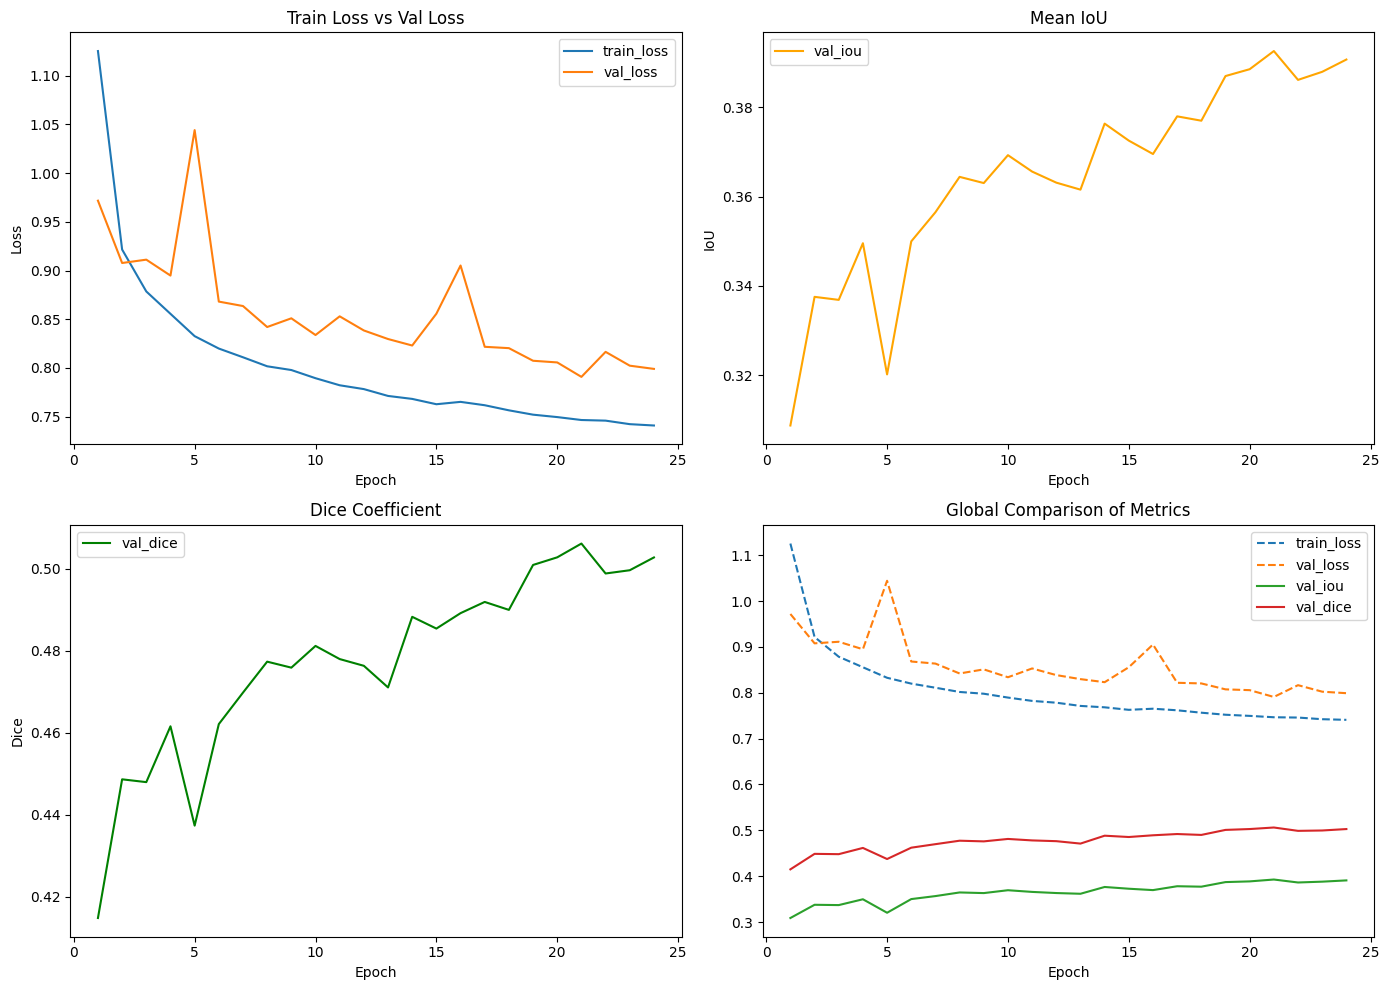

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Chemin ajusté pour accéder au fichier des métriques
metrics_file_path = os.path.join(os.getcwd(), "data", "metrics_dilatednet.csv")

# Chargement des métriques
metrics_df = pd.read_csv(metrics_file_path)

# Création de sous-graphiques pour visualiser les métriques
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Train Loss vs Val Loss
axs[0, 0].plot(metrics_df["epoch"], metrics_df["train_loss"], label="train_loss")
axs[0, 0].plot(metrics_df["epoch"], metrics_df["val_loss"], label="val_loss")
axs[0, 0].set_title("Train Loss vs Val Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()

# IoU pour train et val
axs[0, 1].plot(metrics_df["epoch"], metrics_df["iou"], label="val_iou", color="orange")
axs[0, 1].set_title("Mean IoU")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("IoU")
axs[0, 1].legend()

# Dice pour train et val
axs[1, 0].plot(metrics_df["epoch"], metrics_df["dice"], label="val_dice", color="green")
axs[1, 0].set_title("Dice Coefficient")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Dice")
axs[1, 0].legend()

# Comparaison globale de toutes les métriques
axs[1, 1].plot(metrics_df["epoch"], metrics_df["train_loss"], label="train_loss", linestyle="--")
axs[1, 1].plot(metrics_df["epoch"], metrics_df["val_loss"], label="val_loss", linestyle="--")
axs[1, 1].plot(metrics_df["epoch"], metrics_df["iou"], label="val_iou", linestyle="-")
axs[1, 1].plot(metrics_df["epoch"], metrics_df["dice"], label="val_dice", linestyle="-")
axs[1, 1].set_title("Global Comparison of Metrics")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].legend()

# Ajuster la mise en page
plt.tight_layout()
plt.show()

### Observations combinées pour le modèle **DilatedNet** :

---

#### **Évolution des métriques (graphiques et données chiffrées)** :

1. **Train Loss vs Val Loss** :
   - La perte d'entraînement (`train_loss`) diminue régulièrement, ce qui indique que le modèle apprend bien les données d'entraînement.
   - La perte de validation (`val_loss`) suit une tendance descendante, mais avec des fluctuations, notamment entre les époques 5 et 15, suggérant un possible surapprentissage ou des défis de généralisation.

2. **IoU (Intersection over Union)** :
   - L'IoU moyen pour la validation atteint **0.3907** à la 24e époque, montrant une amélioration continue mais insuffisante pour des scénarios critiques comme la segmentation dans une voiture autonome (un IoU > 0.7 est souvent requis).

3. **Coefficient de Dice** :
   - Le coefficient de Dice progresse régulièrement pour atteindre **0.5027** à la fin de l'entraînement. Ce score est modéré, reflétant une segmentation acceptable pour des tâches simples, mais insuffisant pour des applications critiques nécessitant une précision élevée.

4. **Comparaison globale des métriques** :
   - Les tendances de `train_loss` et `val_loss` indiquent une bonne convergence, mais l'écart entre les deux suggère des difficultés de généralisation. 
   - Les scores IoU et Dice montrent une progression cohérente, mais leur niveau absolu reste faible pour des tâches exigeantes comme la segmentation dans le cadre de véhicules autonomes.

---

#### **Problèmes identifiés** :
1. **Qualité des métriques** :
   - Un IoU de **0.3907** et un Dice de **0.5027** sont bien en dessous des attentes pour une segmentation de qualité dans un contexte autonome.
   - Ces scores montrent que le modèle ne parvient pas à détecter avec précision des classes critiques comme les routes, les piétons ou les véhicules.

2. **Fluctuations des pertes de validation** :
   - Les fluctuations de `val_loss` après quelques époques peuvent indiquer un surapprentissage ou un manque de diversité dans les données de validation.

3. **Risque de sous-performance sur des scènes non vues** :
   - L’écart entre `train_loss` et `val_loss` pourrait entraîner des performances faibles dans des environnements réels, où la généralisation est essentielle.

---

#### **Points d'amélioration suggérés** :
1. **Augmentations de données** :
   - Ajouter des augmentations spécifiques aux véhicules autonomes : simulation de conditions climatiques (pluie, neige), variations de luminosité (jour/nuit), bruit, transformations géométriques (rotations, translations).

2. **Amélioration de l'architecture** :
   - Remplacer ou compléter le modèle **DilatedNet** avec des architectures d’état de l’art comme **DeepLabV3+**, **SegFormer**, ou **HRNet**, plus adaptées aux tâches de segmentation complexes.
   - Intégrer des mécanismes d’attention pour mieux modéliser les relations spatiales et contextuelles dans l'image.

3. **Optimisation des hyperparamètres** :
   - Réduire progressivement le **learning rate** en utilisant un scheduler.
   - Appliquer une régularisation supplémentaire comme le Dropout ou des poids L2 pour limiter le surapprentissage.

4. **Données supplémentaires** :
   - Complétez le dataset avec des données variées issues de bases comme **KITTI** ou **nuScenes**.

5. **Validation croisée** :
   - Mettre en place une validation croisée pour évaluer la stabilité des résultats sur plusieurs sous-ensembles.

---

#### **Conclusion** :
Le modèle **DilatedNet** montre une bonne progression, mais ses métriques (IoU : **0.39**, Dice : **0.50**) sont insuffisantes pour des applications critiques comme les voitures autonomes. Pour une mise en production :
- **Visez un IoU > 0.7** et un **Dice > 0.85** sur les classes clés (routes, piétons, véhicules).
- Améliorez la généralisation grâce à des architectures modernes et une gestion rigoureuse des données.

La priorité doit être donnée à l’augmentation de la précision et à la stabilité des performances pour garantir la sécurité et la fiabilité dans des conditions réelles.

### 2. VGG16 Unet Pipeline :
- Pour améliorer les performances et répondre aux exigences critiques de précision dans le cadre de la segmentation d'images pour les voitures autonomes, nous allons maintenant explorer une nouvelle approche en mettant en place une **pipeline basée sur VGG16 U-Net**.


In [6]:
import os
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.transforms import functional as TF

# Détection du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chemins
base_dir = os.path.join(os.getcwd(), 'data')
train_image_dir = os.path.join(base_dir, 'leftImg8bit', 'train')
train_mask_dir = os.path.join(base_dir, 'gtFine', 'train')
val_image_dir = os.path.join(base_dir, 'leftImg8bit', 'val')
val_mask_dir = os.path.join(base_dir, 'gtFine', 'val')

model_save_path = os.path.join(os.getcwd(), "models", "vgg16_unet_model.pth")
metrics_file_path = os.path.join(base_dir, "metrics_vgg16_unet.csv")

# Mapping des catégories
cats = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}
category_mapping = {subclass: idx for idx, (cat, subclasses) in enumerate(cats.items()) for subclass in subclasses}

# Transformations des données
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

class Augmentations:
    def __call__(self, image, mask):
        if torch.rand(1).item() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        angle = torch.randint(-10, 10, (1,)).item()
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)
        color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
        image = color_jitter(image)
        return image, mask

class CityscapesDataset:
    def __init__(self, image_dir, mask_dir, transform=None, augmentations=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.augmentations = augmentations
        self.images = []
        self.masks = []

        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".png"):
                    image_path = os.path.join(root, file)
                    mask_path = os.path.join(mask_dir, root.split(os.sep)[-1],
                                             file.replace("_leftImg8bit.png", "_gtFine_labelIds.png"))
                    if os.path.exists(mask_path):
                        self.images.append(image_path)
                        self.masks.append(mask_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx])
        if self.augmentations:
            image, mask = self.augmentations(image, mask)
        if self.transform:
            image = self.transform(image)
            mask = mask.resize((256, 256))
            mask = np.array(mask)
            mapped_mask = np.zeros_like(mask, dtype=np.long)
            for val, cat_idx in category_mapping.items():
                mapped_mask[mask == val] = cat_idx
            mask = torch.tensor(mapped_mask, dtype=torch.long)
        return image, mask

augmentations = Augmentations()

train_dataset = CityscapesDataset(
    image_dir=train_image_dir,
    mask_dir=train_mask_dir,
    transform=transform,
    augmentations=augmentations
)
val_dataset = CityscapesDataset(
    image_dir=val_image_dir,
    mask_dir=val_mask_dir,
    transform=transform,
    augmentations=None
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

class VGG16UNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(VGG16UNet, self).__init__()
        vgg16 = models.vgg16(pretrained=pretrained)
        features = list(vgg16.features.children())
        self.enc1 = nn.Sequential(*features[:5])
        self.enc2 = nn.Sequential(*features[5:10])
        self.enc3 = nn.Sequential(*features[10:17])
        self.enc4 = nn.Sequential(*features[17:24])
        self.center = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dec4 = self._decoder_block(512 + 512, 256)
        self.dec3 = self._decoder_block(256 + 256, 128)
        self.dec2 = self._decoder_block(128 + 128, 64)
        self.dec1 = self._decoder_block(64 + 64, 64)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))
        center = self.center(F.max_pool2d(enc4, kernel_size=2))
        dec4 = self.dec4(torch.cat([F.interpolate(center, enc4.size()[2:], mode='bilinear', align_corners=False), enc4], dim=1))
        dec3 = self.dec3(torch.cat([F.interpolate(dec4, enc3.size()[2:], mode='bilinear', align_corners=False), enc3], dim=1))
        dec2 = self.dec2(torch.cat([F.interpolate(dec3, enc2.size()[2:], mode='bilinear', align_corners=False), enc2], dim=1))
        dec1 = self.dec1(torch.cat([F.interpolate(dec2, enc1.size()[2:], mode='bilinear', align_corners=False), enc1], dim=1))
        return F.interpolate(self.final(dec1), x.size()[2:], mode='bilinear', align_corners=False)

def calculate_iou(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    iou = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            iou.append(float('nan'))
        else:
            iou.append(intersection / union)
    return np.nanmean(iou)

def calculate_dice(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    dice = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        dice_score = (2 * intersection) / (pred_inds.sum().item() + target_inds.sum().item() + 1e-7)
        dice.append(dice_score)
    return np.mean(dice)

def train_model_with_early_stopping(model, dataloaders, optimizer, criterion, num_epochs, patience, metrics_file):
    model = model.to(device)
    best_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    metrics_df = pd.DataFrame(columns=["epoch", "train_loss", "val_loss", "iou", "dice"])
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        train_dice = 0.0
        num_batches = 0

        for images, masks in tqdm(dataloaders["train"]):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_iou += calculate_iou(outputs, masks, num_classes)
            train_dice += calculate_dice(outputs, masks, num_classes)
            num_batches += 1

        train_loss /= num_batches
        train_iou /= num_batches
        train_dice /= num_batches

        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        val_dice = 0.0
        num_val_batches = 0

        with torch.no_grad():
            for images, masks in dataloaders["val"]:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                val_iou += calculate_iou(outputs, masks, num_classes)
                val_dice += calculate_dice(outputs, masks, num_classes)
                num_val_batches += 1

        val_loss /= num_val_batches
        val_iou /= num_val_batches
        val_dice /= num_val_batches

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}")

        new_row = pd.DataFrame({
            "epoch": [epoch + 1],
            "train_loss": [train_loss],
            "val_loss": [val_loss],
            "iou": [val_iou],
            "dice": [val_dice]
        })
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = model.state_dict()
            patience_counter = 0
            print("Validation loss improved, saving the model...")
            torch.save(best_model_weights, model_save_path)
        else:
            patience_counter += 1
            print(f"Early stopping patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    metrics_df.to_csv(metrics_file, index=False)
    print(f"Métriques sauvegardées dans {metrics_file}")

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return model

num_classes = 8
model = VGG16UNet(num_classes=num_classes, pretrained=True) # transfert learning
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dataloaders = {"train": train_loader, "val": val_loader}

num_epochs = 25
patience = 3

model = train_model_with_early_stopping(
    model,
    dataloaders,
    optimizer,
    criterion,
    num_epochs=num_epochs,
    patience=patience,
    metrics_file=metrics_file_path
)

print(f"Model saved at {model_save_path}")


C:\P8d\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\P8d\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25


100%|██████████| 186/186 [07:19<00:00,  2.36s/it]
C:\Users\pat\AppData\Local\Temp\ipykernel_4184\786347731.py:237: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


Train Loss: 0.8215, Val Loss: 0.6310, IoU: 0.4648, Dice: 0.5643
Validation loss improved, saving the model...
Epoch 2/25


100%|██████████| 186/186 [07:26<00:00,  2.40s/it]


Train Loss: 0.5108, Val Loss: 0.5576, IoU: 0.4893, Dice: 0.5855
Validation loss improved, saving the model...
Epoch 3/25


100%|██████████| 186/186 [07:04<00:00,  2.28s/it]


Train Loss: 0.4647, Val Loss: 0.5219, IoU: 0.5294, Dice: 0.6294
Validation loss improved, saving the model...
Epoch 4/25


100%|██████████| 186/186 [07:07<00:00,  2.30s/it]


Train Loss: 0.4312, Val Loss: 0.4947, IoU: 0.5392, Dice: 0.6372
Validation loss improved, saving the model...
Epoch 5/25


100%|██████████| 186/186 [07:07<00:00,  2.30s/it]


Train Loss: 0.4169, Val Loss: 0.4608, IoU: 0.5673, Dice: 0.6698
Validation loss improved, saving the model...
Epoch 6/25


100%|██████████| 186/186 [07:10<00:00,  2.31s/it]


Train Loss: 0.4085, Val Loss: 0.4474, IoU: 0.5717, Dice: 0.6737
Validation loss improved, saving the model...
Epoch 7/25


100%|██████████| 186/186 [07:04<00:00,  2.28s/it]


Train Loss: 0.3905, Val Loss: 0.4524, IoU: 0.5807, Dice: 0.6826
Early stopping patience counter: 1/3
Epoch 8/25


100%|██████████| 186/186 [07:03<00:00,  2.28s/it]


Train Loss: 0.3843, Val Loss: 0.4471, IoU: 0.5797, Dice: 0.6847
Validation loss improved, saving the model...
Epoch 9/25


100%|██████████| 186/186 [07:03<00:00,  2.27s/it]


Train Loss: 0.3724, Val Loss: 0.4209, IoU: 0.5952, Dice: 0.7020
Validation loss improved, saving the model...
Epoch 10/25


100%|██████████| 186/186 [07:02<00:00,  2.27s/it]


Train Loss: 0.3646, Val Loss: 0.4181, IoU: 0.5981, Dice: 0.7025
Validation loss improved, saving the model...
Epoch 11/25


100%|██████████| 186/186 [07:01<00:00,  2.27s/it]


Train Loss: 0.3559, Val Loss: 0.4661, IoU: 0.5811, Dice: 0.6885
Early stopping patience counter: 1/3
Epoch 12/25


100%|██████████| 186/186 [07:02<00:00,  2.27s/it]


Train Loss: 0.3518, Val Loss: 0.4235, IoU: 0.6034, Dice: 0.7103
Early stopping patience counter: 2/3
Epoch 13/25


100%|██████████| 186/186 [07:01<00:00,  2.26s/it]


Train Loss: 0.3471, Val Loss: 0.4130, IoU: 0.6058, Dice: 0.7102
Validation loss improved, saving the model...
Epoch 14/25


100%|██████████| 186/186 [07:01<00:00,  2.27s/it]


Train Loss: 0.3459, Val Loss: 0.4056, IoU: 0.6095, Dice: 0.7157
Validation loss improved, saving the model...
Epoch 15/25


100%|██████████| 186/186 [07:01<00:00,  2.27s/it]


Train Loss: 0.3369, Val Loss: 0.4176, IoU: 0.6150, Dice: 0.7202
Early stopping patience counter: 1/3
Epoch 16/25


100%|██████████| 186/186 [07:01<00:00,  2.27s/it]


Train Loss: 0.3328, Val Loss: 0.4081, IoU: 0.6080, Dice: 0.7155
Early stopping patience counter: 2/3
Epoch 17/25


100%|██████████| 186/186 [07:01<00:00,  2.27s/it]


Train Loss: 0.3269, Val Loss: 0.4028, IoU: 0.6157, Dice: 0.7232
Validation loss improved, saving the model...
Epoch 18/25


100%|██████████| 186/186 [07:02<00:00,  2.27s/it]


Train Loss: 0.3206, Val Loss: 0.4255, IoU: 0.6127, Dice: 0.7187
Early stopping patience counter: 1/3
Epoch 19/25


100%|██████████| 186/186 [07:22<00:00,  2.38s/it]


Train Loss: 0.3232, Val Loss: 0.4325, IoU: 0.6006, Dice: 0.7083
Early stopping patience counter: 2/3
Epoch 20/25


100%|██████████| 186/186 [07:07<00:00,  2.30s/it]


Train Loss: 0.3224, Val Loss: 0.4120, IoU: 0.6074, Dice: 0.7132
Early stopping patience counter: 3/3
Early stopping triggered.
Total training time: 9215.74 seconds
Métriques sauvegardées dans D:\OC_IA\P8\OC_IA_P8_VoitureAutonome\data\metrics_vgg16_unet.csv
Model saved at D:\OC_IA\P8\OC_IA_P8_VoitureAutonome\models\vgg16_unet_model.pth


### Sauvegarde du modèle complet pour une utilisation future (inference)

In [17]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Recréer l'architecture du modèle
class VGG16UNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(VGG16UNet, self).__init__()
        vgg16 = models.vgg16(pretrained=pretrained)
        features = list(vgg16.features.children())
        self.enc1 = nn.Sequential(*features[:5])
        self.enc2 = nn.Sequential(*features[5:10])
        self.enc3 = nn.Sequential(*features[10:17])
        self.enc4 = nn.Sequential(*features[17:24])
        self.center = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dec4 = self._decoder_block(512 + 512, 256)
        self.dec3 = self._decoder_block(256 + 256, 128)
        self.dec2 = self._decoder_block(128 + 128, 64)
        self.dec1 = self._decoder_block(64 + 64, 64)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))
        center = self.center(F.max_pool2d(enc4, kernel_size=2))
        dec4 = self.dec4(torch.cat([F.interpolate(center, enc4.size()[2:], mode='bilinear', align_corners=False), enc4], dim=1))
        dec3 = self.dec3(torch.cat([F.interpolate(dec4, enc3.size()[2:], mode='bilinear', align_corners=False), enc3], dim=1))
        dec2 = self.dec2(torch.cat([F.interpolate(dec3, enc2.size()[2:], mode='bilinear', align_corners=False), enc2], dim=1))
        dec1 = self.dec1(torch.cat([F.interpolate(dec2, enc1.size()[2:], mode='bilinear', align_corners=False), enc1], dim=1))
        return F.interpolate(self.final(dec1), x.size()[2:], mode='bilinear', align_corners=False)

# Détection du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Définir le nombre de classes
num_classes = 8

# Charger l'architecture du modèle
model = VGG16UNet(num_classes=num_classes, pretrained=True).to(device)

# Charger les poids enregistrés
weights_path = os.path.join(os.getcwd(), "models", "vgg16_unet_model.pth")
model.load_state_dict(torch.load(weights_path, map_location=device))

# Sauvegarder le modèle complet
complete_model_save_path = os.path.join(os.getcwd(), "models", "vgg16_unet_complete_model.pth")
torch.save(model, complete_model_save_path)
print(f"Modèle complet sauvegardé dans {complete_model_save_path}")


Using device: cuda


C:\P8d\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\P8d\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Modèle complet sauvegardé dans D:\OC_IA\P8\OC_IA_P8_VoitureAutonome\models\vgg16_unet_complete_model.pth


C:\Users\pat\AppData\Local\Temp\ipykernel_19628\1561697714.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=d

### Visualisation des métriques d'entraînement pour VGG16-Unet

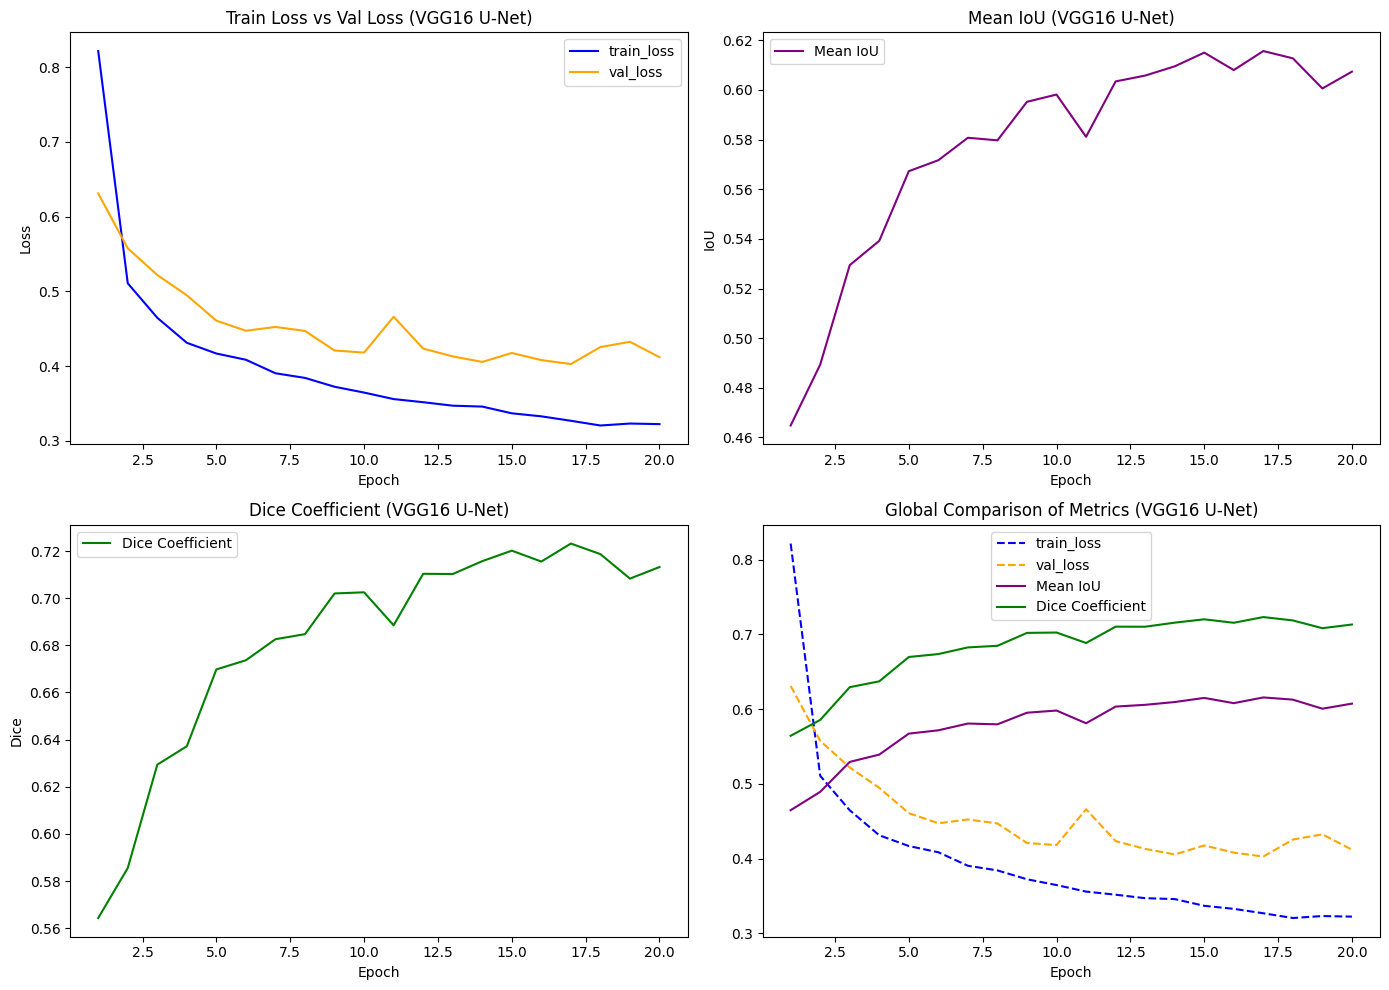

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Chemin ajusté pour accéder au fichier des métriques du modèle VGG16 U-Net
metrics_file_path = os.path.join(os.getcwd(), "data", "metrics_vgg16_unet.csv")

# Chargement des métriques
metrics_df = pd.read_csv(metrics_file_path)

# Création de sous-graphiques pour visualiser les métriques
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Train Loss vs Val Loss
axs[0, 0].plot(metrics_df["epoch"], metrics_df["train_loss"], label="train_loss", color="blue")
axs[0, 0].plot(metrics_df["epoch"], metrics_df["val_loss"], label="val_loss", color="orange")
axs[0, 0].set_title("Train Loss vs Val Loss (VGG16 U-Net)")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()

# IoU pour train et val
axs[0, 1].plot(metrics_df["epoch"], metrics_df["iou"], label="Mean IoU", color="purple")
axs[0, 1].set_title("Mean IoU (VGG16 U-Net)")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("IoU")
axs[0, 1].legend()

# Dice pour train et val
axs[1, 0].plot(metrics_df["epoch"], metrics_df["dice"], label="Dice Coefficient", color="green")
axs[1, 0].set_title("Dice Coefficient (VGG16 U-Net)")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Dice")
axs[1, 0].legend()

# Comparaison globale de toutes les métriques
axs[1, 1].plot(metrics_df["epoch"], metrics_df["train_loss"], label="train_loss", linestyle="--", color="blue")
axs[1, 1].plot(metrics_df["epoch"], metrics_df["val_loss"], label="val_loss", linestyle="--", color="orange")
axs[1, 1].plot(metrics_df["epoch"], metrics_df["iou"], label="Mean IoU", linestyle="-", color="purple")
axs[1, 1].plot(metrics_df["epoch"], metrics_df["dice"], label="Dice Coefficient", linestyle="-", color="green")
axs[1, 1].set_title("Global Comparison of Metrics (VGG16 U-Net)")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].legend()

# Ajuster la mise en page
plt.tight_layout()
plt.show()


### Observations comparées : **VGG16 U-Net** vs **DilatedNet**

1. **Train Loss vs Val Loss** :
   - **VGG16 U-Net** montre une meilleure convergence avec moins de fluctuations dans la validation, contrairement à DilatedNet qui présente des variations plus marquées.
   - Les pertes sont globalement plus faibles avec VGG16 U-Net, indiquant un apprentissage plus efficace.

2. **IoU (Intersection over Union)** :
   - **VGG16 U-Net** atteint un IoU moyen de **0.61**, nettement supérieur à celui de DilatedNet (**0.39**), mais encore insuffisant pour des scénarios critiques (> **0.7** recommandé).

3. **Coefficient de Dice** :
   - **VGG16 U-Net** obtient un Dice de **0.72**, montrant une segmentation plus précise par rapport à DilatedNet (**0.50**), mais des améliorations sont encore nécessaires pour des cas d’usage critiques.

---

### Conclusion comparée :
- **VGG16 U-Net** surpasse DilatedNet en termes de stabilité et de précision, avec des métriques significativement meilleures.
- Cependant, pour une mise en production dans un cadre de voiture autonome, les deux modèles nécessitent des améliorations, notamment pour atteindre un **IoU > 0.7** et un **Dice > 0.85**.
- VGG16 U-Net est une base plus prometteuse. 

### 3. Code pour U-Net Mini avec Transfert Learning


In [2]:
import os
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.transforms import functional as TF


# Activer CUDA_LAUNCH_BLOCKING pour faciliter le débogage
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Détection du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chemins
base_dir = os.path.join(os.getcwd(), 'data')
train_image_dir = os.path.join(base_dir, 'leftImg8bit', 'train')
train_mask_dir = os.path.join(base_dir, 'gtFine', 'train')
val_image_dir = os.path.join(base_dir, 'leftImg8bit', 'val')
val_mask_dir = os.path.join(base_dir, 'gtFine', 'val')

model_save_path = os.path.join(os.getcwd(), "models", "unet_mini_model.pth")
metrics_file_path = os.path.join(base_dir, "metrics_unet_mini.csv")

# Mapping des catégories
cats = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}
category_mapping = {subclass: idx for idx, (cat, subclasses) in enumerate(cats.items()) for subclass in subclasses}

# Transformations des données
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

class Augmentations:
    def __call__(self, image, mask):
        if torch.rand(1).item() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        angle = torch.randint(-10, 10, (1,)).item()
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)
        color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
        image = color_jitter(image)
        return image, mask


class CityscapesDataset:
    def __init__(self, image_dir, mask_dir, transform=None, augmentations=None, num_classes=8):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.augmentations = augmentations
        self.num_classes = num_classes
        self.images = []
        self.masks = []

        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".png"):
                    image_path = os.path.join(root, file)
                    mask_path = os.path.join(mask_dir, root.split(os.sep)[-1],
                                             file.replace("_leftImg8bit.png", "_gtFine_labelIds.png"))
                    if os.path.exists(mask_path):
                        self.images.append(image_path)
                        self.masks.append(mask_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx])
        if self.augmentations:
            image, mask = self.augmentations(image, mask)
        if self.transform:
            image = self.transform(image)
            mask = mask.resize((256, 256), resample=Image.NEAREST)
            mask = np.array(mask, dtype=np.long)

            # Remap des catégories
            mapped_mask = np.zeros_like(mask, dtype=np.long)
            for val, cat_idx in category_mapping.items():
                mapped_mask[mask == val] = cat_idx

            # Vérification des indices des masques
            mapped_mask[mapped_mask >= self.num_classes] = self.num_classes - 1
            mapped_mask[mapped_mask < 0] = 0
            mask = torch.tensor(mapped_mask, dtype=torch.long)

            # Vérification après remap
            if torch.any(mask >= self.num_classes) or torch.any(mask < 0):
                raise ValueError(f"Mask contains invalid indices. Unique values: {torch.unique(mask)}")
        return image, mask



augmentations = Augmentations()

train_dataset = CityscapesDataset(
    image_dir=train_image_dir,
    mask_dir=train_mask_dir,
    transform=transform,
    augmentations=augmentations
)
val_dataset = CityscapesDataset(
    image_dir=val_image_dir,
    mask_dir=val_mask_dir,
    transform=transform,
    augmentations=None
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

class UNetMini(nn.Module):
    def __init__(self, num_classes):
        super(UNetMini, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.enc1 = nn.Sequential(*list(resnet.children())[:3])
        self.enc2 = nn.Sequential(*list(resnet.children())[3:5])
        self.enc3 = nn.Sequential(*list(resnet.children())[5])
        self.enc4 = nn.Sequential(*list(resnet.children())[6])
        self.center = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.dec4 = self._decoder_block(512 + 256, 256)
        self.dec3 = self._decoder_block(256 + 128, 128)
        self.dec2 = self._decoder_block(128 + 64, 64)
        self.dec1 = self._decoder_block(64 + 64, 64)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))
        center = self.center(F.max_pool2d(enc4, kernel_size=2))
        dec4 = self.dec4(torch.cat([F.interpolate(center, enc4.size()[2:], mode='bilinear', align_corners=False), enc4], dim=1))
        dec3 = self.dec3(torch.cat([F.interpolate(dec4, enc3.size()[2:], mode='bilinear', align_corners=False), enc3], dim=1))
        dec2 = self.dec2(torch.cat([F.interpolate(dec3, enc2.size()[2:], mode='bilinear', align_corners=False), enc2], dim=1))
        dec1 = self.dec1(torch.cat([F.interpolate(dec2, enc1.size()[2:], mode='bilinear', align_corners=False), enc1], dim=1))
        return F.interpolate(self.final(dec1), x.size()[2:], mode='bilinear', align_corners=False)

def calculate_dice(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    dice = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        dice_score = (2 * intersection) / (pred_inds.sum().item() + target_inds.sum().item() + 1e-7)
        dice.append(dice_score)
    return np.mean(dice)

def calculate_iou(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    iou = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            iou.append(float('nan'))
        else:
            iou.append(intersection / union)
    return np.nanmean(iou)

def train_model_with_metrics(model, dataloaders, optimizer, criterion, num_epochs=25, patience=3):
    best_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    metrics_df = pd.DataFrame(columns=["epoch", "train_loss", "val_loss", "iou", "dice"])
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        train_dice = 0.0
        num_batches = 0

        for images, masks in tqdm(dataloaders["train"]):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_iou += calculate_iou(outputs, masks, num_classes=8)
            train_dice += calculate_dice(outputs, masks, num_classes=8)
            num_batches += 1

        train_loss /= num_batches
        train_iou /= num_batches
        train_dice /= num_batches

        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        val_dice = 0.0
        num_val_batches = 0

        with torch.no_grad():
            for images, masks in dataloaders["val"]:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                val_iou += calculate_iou(outputs, masks, num_classes=8)
                val_dice += calculate_dice(outputs, masks, num_classes=8)
                num_val_batches += 1

        val_loss /= num_val_batches
        val_iou /= num_val_batches
        val_dice /= num_val_batches

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}")

        new_row = {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "iou": val_iou,
            "dice": val_dice
        }
        metrics_df = pd.concat([metrics_df, pd.DataFrame([new_row])], ignore_index=True)


        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = model.state_dict()
            patience_counter = 0
            torch.save(best_model_weights, model_save_path)
            print("Validation loss improved, saving the model...")
        else:
            patience_counter += 1
            print(f"Patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    metrics_df.to_csv(metrics_file_path, index=False)
    print(f"Métriques sauvegardées dans {metrics_file_path}")

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return model

num_classes = 8
model = UNetMini(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dataloaders = {"train": train_loader, "val": val_loader}

model = train_model_with_metrics(model, dataloaders, optimizer, criterion, num_epochs=25, patience=3)


Epoch 1/25


100%|██████████| 186/186 [06:51<00:00,  2.21s/it]
C:\Users\pat\AppData\Local\Temp\ipykernel_21056\400867243.py:253: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([new_row])], ignore_index=True)


Train Loss: 0.8328, Val Loss: 0.6671, IoU: 0.4508, Dice: 0.5513
Validation loss improved, saving the model...
Epoch 2/25


100%|██████████| 186/186 [06:54<00:00,  2.23s/it]


Train Loss: 0.4824, Val Loss: 0.5194, IoU: 0.5222, Dice: 0.6255
Validation loss improved, saving the model...
Epoch 3/25


100%|██████████| 186/186 [06:50<00:00,  2.21s/it]


Train Loss: 0.4361, Val Loss: 0.5281, IoU: 0.5311, Dice: 0.6346
Patience counter: 1/3
Epoch 4/25


100%|██████████| 186/186 [06:35<00:00,  2.13s/it]


Train Loss: 0.4108, Val Loss: 0.4958, IoU: 0.5368, Dice: 0.6444
Validation loss improved, saving the model...
Epoch 5/25


100%|██████████| 186/186 [06:34<00:00,  2.12s/it]


Train Loss: 0.3931, Val Loss: 0.4877, IoU: 0.5530, Dice: 0.6549
Validation loss improved, saving the model...
Epoch 6/25


100%|██████████| 186/186 [06:35<00:00,  2.12s/it]


Train Loss: 0.3822, Val Loss: 0.4860, IoU: 0.5543, Dice: 0.6602
Validation loss improved, saving the model...
Epoch 7/25


100%|██████████| 186/186 [06:35<00:00,  2.13s/it]


Train Loss: 0.3683, Val Loss: 0.4491, IoU: 0.5713, Dice: 0.6757
Validation loss improved, saving the model...
Epoch 8/25


100%|██████████| 186/186 [06:34<00:00,  2.12s/it]


Train Loss: 0.3582, Val Loss: 0.4171, IoU: 0.5830, Dice: 0.6865
Validation loss improved, saving the model...
Epoch 9/25


100%|██████████| 186/186 [06:33<00:00,  2.12s/it]


Train Loss: 0.3554, Val Loss: 0.4191, IoU: 0.5844, Dice: 0.6854
Patience counter: 1/3
Epoch 10/25


100%|██████████| 186/186 [06:34<00:00,  2.12s/it]


Train Loss: 0.3503, Val Loss: 0.4527, IoU: 0.5816, Dice: 0.6896
Patience counter: 2/3
Epoch 11/25


100%|██████████| 186/186 [06:34<00:00,  2.12s/it]


Train Loss: 0.3417, Val Loss: 0.4622, IoU: 0.5881, Dice: 0.6967
Patience counter: 3/3
Early stopping triggered.
Total training time: 4748.43 seconds
Métriques sauvegardées dans D:\OC_IA\P8\OC_IA_P8_VoitureAutonome\data\metrics_unet_mini.csv


In [18]:
### Sauvegarde du modèle complet pour une utilisation future (inference)import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Recréer l'architecture du modèle U-Net Mini
class UNetMini(nn.Module):
    def __init__(self, num_classes):
        super(UNetMini, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.enc1 = nn.Sequential(*list(resnet.children())[:3])
        self.enc2 = nn.Sequential(*list(resnet.children())[3:5])
        self.enc3 = nn.Sequential(*list(resnet.children())[5])
        self.enc4 = nn.Sequential(*list(resnet.children())[6])
        self.center = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.dec4 = self._decoder_block(512 + 256, 256)
        self.dec3 = self._decoder_block(256 + 128, 128)
        self.dec2 = self._decoder_block(128 + 64, 64)
        self.dec1 = self._decoder_block(64 + 64, 64)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))
        center = self.center(F.max_pool2d(enc4, kernel_size=2))
        dec4 = self.dec4(torch.cat([F.interpolate(center, enc4.size()[2:], mode='bilinear', align_corners=False), enc4], dim=1))
        dec3 = self.dec3(torch.cat([F.interpolate(dec4, enc3.size()[2:], mode='bilinear', align_corners=False), enc3], dim=1))
        dec2 = self.dec2(torch.cat([F.interpolate(dec3, enc2.size()[2:], mode='bilinear', align_corners=False), enc2], dim=1))
        dec1 = self.dec1(torch.cat([F.interpolate(dec2, enc1.size()[2:], mode='bilinear', align_corners=False), enc1], dim=1))
        return F.interpolate(self.final(dec1), x.size()[2:], mode='bilinear', align_corners=False)

# Détection du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Définir le nombre de classes
num_classes = 8

# Charger l'architecture du modèle
model = UNetMini(num_classes=num_classes).to(device)

# Chemin du fichier contenant les poids enregistrés
weights_path = os.path.join(os.getcwd(), "models", "unet_mini_model.pth")

# Charger les meilleurs poids
model.load_state_dict(torch.load(weights_path, map_location=device))

# Sauvegarder le modèle complet
complete_model_save_path = os.path.join(os.getcwd(), "models", "unet_mini_complete_model.pth")
torch.save(model, complete_model_save_path)

print(f"Modèle complet sauvegardé dans {complete_model_save_path}")


Using device: cuda
Modèle complet sauvegardé dans D:\OC_IA\P8\OC_IA_P8_VoitureAutonome\models\unet_mini_complete_model.pth


C:\Users\pat\AppData\Local\Temp\ipykernel_19628\2758872400.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=d

### Visualisation des métriques d'entraînement pour U-Net Mini

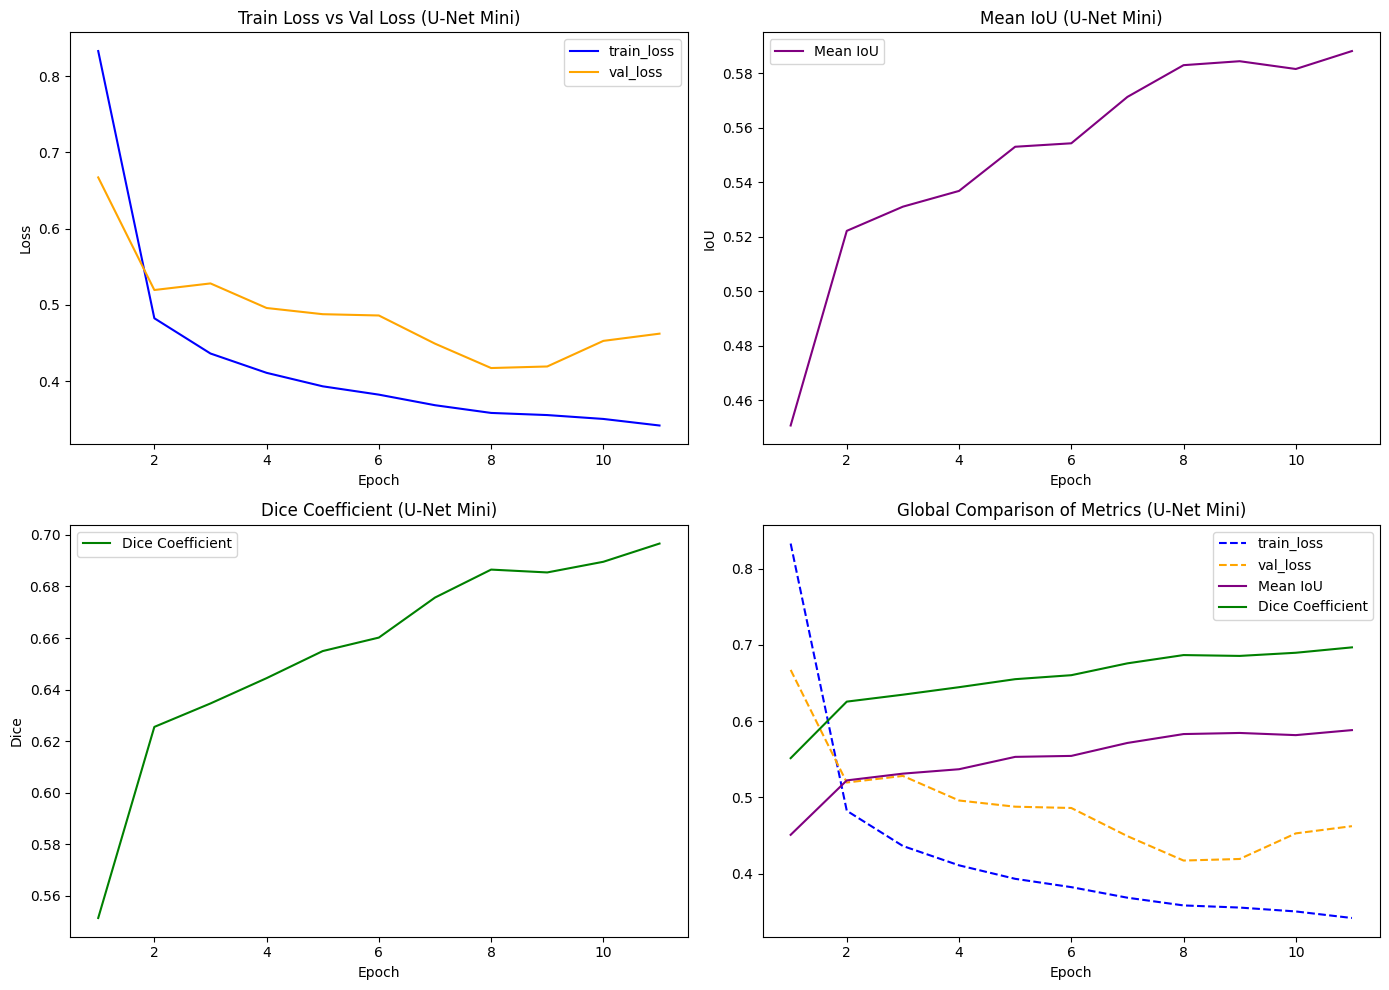

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Chemin ajusté pour accéder au fichier des métriques du modèle U-Net Mini
metrics_file_path = os.path.join(os.getcwd(), "data", "metrics_unet_mini.csv")

# Chargement des métriques
metrics_df = pd.read_csv(metrics_file_path)

# Création de sous-graphiques pour visualiser les métriques
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Train Loss vs Val Loss
axs[0, 0].plot(metrics_df["epoch"], metrics_df["train_loss"], label="train_loss", color="blue")
axs[0, 0].plot(metrics_df["epoch"], metrics_df["val_loss"], label="val_loss", color="orange")
axs[0, 0].set_title("Train Loss vs Val Loss (U-Net Mini)")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()

# IoU pour train et val
axs[0, 1].plot(metrics_df["epoch"], metrics_df["iou"], label="Mean IoU", color="purple")
axs[0, 1].set_title("Mean IoU (U-Net Mini)")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("IoU")
axs[0, 1].legend()

# Dice pour train et val
axs[1, 0].plot(metrics_df["epoch"], metrics_df["dice"], label="Dice Coefficient", color="green")
axs[1, 0].set_title("Dice Coefficient (U-Net Mini)")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Dice")
axs[1, 0].legend()

# Comparaison globale de toutes les métriques
axs[1, 1].plot(metrics_df["epoch"], metrics_df["train_loss"], label="train_loss", linestyle="--", color="blue")
axs[1, 1].plot(metrics_df["epoch"], metrics_df["val_loss"], label="val_loss", linestyle="--", color="orange")
axs[1, 1].plot(metrics_df["epoch"], metrics_df["iou"], label="Mean IoU", linestyle="-", color="purple")
axs[1, 1].plot(metrics_df["epoch"], metrics_df["dice"], label="Dice Coefficient", linestyle="-", color="green")
axs[1, 1].set_title("Global Comparison of Metrics (U-Net Mini)")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].legend()

# Ajuster la mise en page
plt.tight_layout()
plt.show()


## Observations pour **U-Net Mini** :

1. **Train Loss vs Val Loss** :
   - **U-Net Mini** montre une bonne convergence avec une réduction progressive des pertes d'entraînement et de validation. Cependant, on observe des fluctuations au niveau de la validation (particulièrement visible après l'epoch 9), indiquant un possible surapprentissage.
   - Les pertes d'entraînement et de validation se stabilisent autour de **0.35** et **0.41-0.45**, ce qui reflète un apprentissage global efficace.

2. **IoU (Intersection over Union)** :
   - **U-Net Mini** atteint un IoU moyen de **0.58** à l'epoch final. C'est une amélioration constante tout au long des epochs, montrant une capacité croissante à bien segmenter les classes.
   - Toutefois, cette métrique reste en deçà des attentes pour des applications critiques (recommandé **> 0.7** pour les voitures autonomes).

3. **Coefficient de Dice** :
   - Le **Dice Coefficient** augmente régulièrement, atteignant **0.69** à la fin. Cela montre que le modèle segmente les pixels cibles de manière de plus en plus précise.
   - Malgré cela, le résultat reste légèrement insuffisant pour des cas critiques où un Dice supérieur à **0.85** est recommandé.

---

### Conclusion pour **U-Net Mini** :
- **U-Net Mini** montre une convergence et des métriques solides, mais son IoU (**0.58**) et son Dice (**0.69**) restent insuffisants pour des applications dans des scénarios critiques.
- Le modèle présente un apprentissage prometteur mais devra être amélioré :
  - Optimisation des hyperparamètres (taux d'apprentissage, régularisation).
  - Utilisation de données supplémentaires ou d'une architecture plus complexe.
  - Réduction des fluctuations observées après l'epoch 9 pour éviter le surapprentissage.
- **U-Net Mini** est une base efficace pour des tâches de segmentation, mais nécessite des ajustements pour répondre aux exigences des véhicules autonomes.

## Synthèse comparative des modèles :

In [6]:
import pandas as pd
import os

# Chemins vers les fichiers des métriques
base_path = os.path.join(os.getcwd(), "data")
metrics_unet_mini_path = os.path.join(base_path, "metrics_unet_mini.csv")
metrics_vgg16_unet_path = os.path.join(base_path, "metrics_vgg16_unet.csv")
metrics_dilatednet_path = os.path.join(base_path, "metrics_dilatednet.csv")

# Chargement des métriques
metrics_unet_mini = pd.read_csv(metrics_unet_mini_path)
metrics_vgg16_unet = pd.read_csv(metrics_vgg16_unet_path)
metrics_dilatednet = pd.read_csv(metrics_dilatednet_path)

# Récupération des métriques finales
summary_data = {
    "U-Net Mini": {
        "loss type": "categorical_crossentropy",
        "val_loss": metrics_unet_mini["val_loss"].iloc[-1],
        "iou": metrics_unet_mini["iou"].iloc[-1],
        "dice": metrics_unet_mini["dice"].iloc[-1],
        "training_time (min)": 4748.43 / 60,  # Conversion en minutes
    },
    "VGG16 U-Net": {
        "loss type": "combine_loss",
        "val_loss": metrics_vgg16_unet["val_loss"].iloc[-1],
        "iou": metrics_vgg16_unet["iou"].iloc[-1],
        "dice": metrics_vgg16_unet["dice"].iloc[-1],
        "training_time (min)": 9215.74 / 60,  # Conversion en minutes
    },
    "DilatedNet": {
        "loss type": "categorical_crossentropy",
        "val_loss": metrics_dilatednet["val_loss"].iloc[-1],
        "iou": metrics_dilatednet["iou"].iloc[-1],
        "dice": metrics_dilatednet["dice"].iloc[-1],
        "training_time (min)": 8287.56 / 60,  # Conversion en minutes
    }
}

# Conversion en DataFrame pour affichage
summary_df = pd.DataFrame.from_dict(summary_data, orient="index")

# Affichage aligné
print("Étude comparative des modèles :")
print(summary_df.to_string(index=True, justify="center"))


Étude comparative des modèles :
                    loss type          val_loss     iou      dice    training_time (min)
U-Net Mini   categorical_crossentropy  0.462157  0.588130  0.696657       79.140500     
VGG16 U-Net              combine_loss  0.411980  0.607362  0.713207      153.595667     
DilatedNet   categorical_crossentropy  0.799034  0.390745  0.502706      138.126000     


### **Observations avant l'inférence sur le dataset de test**

#### **Résumé des performances sur le dataset de validation**
| Modèle         | Val Loss | IoU    | Dice   | Training Time (min) | Avantages                         | Inconvénients                     |
|----------------|----------|--------|--------|----------------------|-----------------------------------|-----------------------------------|
| **U-Net Mini** | 0.462    | 0.588  | 0.697  | 79.14               | Modèle léger, rapide à entraîner. | Légèrement moins performant que VGG16 U-Net. |
| **VGG16 U-Net**| 0.412    | 0.607  | 0.713  | 153.60             | Meilleures métriques globales.     | Long à entraîner et gourmand en ressources. |
| **DilatedNet** | 0.799    | 0.391  | 0.503  | 138.13             | -                                 | Faibles performances globales.    |

#### **1. U-Net Mini**
- Ce modèle offre un bon compromis entre **temps d'entraînement** et **performances**. 
- Avec un **IoU de 0.588** et un **Dice de 0.697**, il est suffisamment performant pour des cas où le temps d'entraînement est limité.
- Son architecture simple le rend également intéressant pour un déploiement rapide et léger, mais il reste légèrement en retrait par rapport à VGG16 U-Net en termes de précision.

#### **2. VGG16 U-Net**
- Ce modèle est **le plus performant** sur le dataset de validation, avec un **IoU de 0.607** et un **Dice de 0.713**.
- Cependant, son **temps d'entraînement est 2 fois plus long** que celui de U-Net Mini, ce qui peut être un facteur limitant dans des environnements où les ressources sont restreintes.
- Ce modèle est idéal si la précision est prioritaire sur le temps d'entraînement.

#### **3. DilatedNet**
- Avec un **IoU de 0.391** et un **Dice de 0.503**, ce modèle est nettement moins performant que les deux autres.
- Il a un temps d'entraînement comparable à VGG16 U-Net mais sans offrir les mêmes bénéfices en précision.
- À ce stade, il semble ne pas être un candidat compétitif.

---

### **Hypothèses et observations avant l'inférence**
1. **U-Net Mini vs VGG16 U-Net** :
   - Les deux modèles sont compétitifs. Si l'inférence sur le dataset de test confirme les tendances du dataset de validation, **VGG16 U-Net** sera le modèle à retenir pour des applications exigeant une segmentation précise.
   - Cependant, si le temps d'inférence est critique, **U-Net Mini** pourrait être préféré pour sa légèreté.

2. **DilatedNet** :
   - Ce modèle est probablement peu compétitif sur le dataset de test. Ses métriques sur le dataset de validation suggèrent qu'il ne généralisera pas aussi bien que les deux autres.

---

### **Conclusion provisoire**
- **U-Net Mini** est une option intéressante pour des scénarios nécessitant un compromis entre **performances** et **efficacité**.
- **VGG16 U-Net** est probablement le modèle à privilégier si les **ressources et le temps d'inférence** ne sont pas des contraintes majeures.
- **DilatedNet** peut être exclu pour le moment en raison de ses performances inférieures.

L'étape suivante est cruciale : évaluer les trois modèles sur le **dataset de test** pour confirmer ces observations. Cela permettra d'évaluer leur capacité à généraliser sur des données complètement nouvelles et d'identifier le meilleur modèle final.

## Inférence sur le dataset de test et évaluation des performances :
- Incluant la reconstruction des architectures et la gestion des poids.
- Reconstruire l'architecture est une bonne pratique :
- En pratique, même si on sauvegarde tout le modèle (torch.save(model)), on peut rencontrer des problèmes de compatibilité si l'environnement (versions de PyTorch, dépendances) change. Sauvegarder uniquement les poids (state_dict) et reconstruire l'architecture est une méthode plus portable et maintenable.

In [14]:
from PIL import Image
import numpy as np
import os

# Chemin vers le masque spécifique
gtFine_path = 'data/gtFine/'  # Dossier principal
image_subfolder = 'train/aachen'  # Sous-dossier
image_name = 'aachen_000000_000019_gtFine_labelIds.png'  # Nom exact de l'image

# Construire le chemin complet vers le masque
mask_path = os.path.join(gtFine_path, image_subfolder, image_name)

# Charger le masque en tant que tableau numpy
mask = np.array(Image.open(mask_path))

# Afficher les valeurs uniques présentes dans le masque
print(f"Valeurs uniques dans le masque '{image_name}' :", np.unique(mask))


Valeurs uniques dans le masque 'aachen_000000_000019_gtFine_labelIds.png' : [ 0  1  3  4  7  8 11 17 20 21 22 23 24 25 26 33]


In [15]:
# Classes attendues selon le category_mapping
from collections import defaultdict

cats = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

# Remappage attendu
category_mapping = defaultdict(list)
for cat_idx, (cat, subclasses) in enumerate(cats.items()):
    for subclass in subclasses:
        category_mapping[subclass] = cat_idx

# Toutes les valeurs uniques attendues
expected_values = list(category_mapping.keys())

# Vérification des valeurs dans le masque
missing_classes = [val for val in expected_values if val not in np.unique(mask)]
unexpected_classes = [val for val in np.unique(mask) if val not in expected_values]

print(f"Classes manquantes dans le masque : {missing_classes}")
print(f"Classes inattendues dans le masque : {unexpected_classes}")


Classes manquantes dans le masque : [2, 5, 6, 9, 10, 12, 13, 14, 15, 16, 18, 19, 27, 28, 29, 30, 31, 32, -1]
Classes inattendues dans le masque : []


In [11]:
import torch
import torch.nn.functional as F
import pandas as pd
import time
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torch import nn
from PIL import Image
import numpy as np
import os

# Détection du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chemins des modèles et des données
base_path = os.path.join(os.getcwd(), "data")
models_path = os.path.join(os.getcwd(), "models")
test_image_dir = os.path.join(base_path, "leftImg8bit", "test")
test_mask_dir = os.path.join(base_path, "gtFine", "test")

model_files = {
    "U-Net Mini": os.path.join(models_path, "unet_mini_model.pth")
}

# Mapping des catégories
cats = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}
category_mapping = {subclass: idx for idx, (cat, subclasses) in enumerate(cats.items()) for subclass in subclasses}

# Dataset de test
class TestDataset:
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = []
        self.masks = []

        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".png"):
                    image_path = os.path.join(root, file)
                    mask_path = os.path.join(mask_dir, root.split(os.sep)[-1],
                                             file.replace("_leftImg8bit.png", "_gtFine_labelIds.png"))
                    if os.path.exists(mask_path):
                        self.images.append(image_path)
                        self.masks.append(mask_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx])
        if self.transform:
            image = self.transform(image)
            mask = mask.resize((256, 256), resample=Image.NEAREST)
            mask = np.array(mask, dtype=np.long)

            # Remap des catégories
            mapped_mask = np.zeros_like(mask, dtype=np.long)
            for val, cat_idx in category_mapping.items():
                mapped_mask[mask == val] = cat_idx

            mask = torch.tensor(mapped_mask, dtype=torch.long)
        return image, mask

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

test_dataset = TestDataset(test_image_dir, test_mask_dir, transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Fonction pour calculer les métriques
def calculate_metrics(model, dataloader, criterion, num_classes):
    model.eval()
    total_loss, total_iou, total_dice = 0.0, 0.0, 0.0
    num_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Calcul des métriques
            pred = torch.argmax(outputs, dim=1)
            for cls in range(num_classes):
                pred_inds = pred == cls
                target_inds = masks == cls
                intersection = (pred_inds & target_inds).sum().item()
                union = (pred_inds | target_inds).sum().item()

                if union > 0:  # Évitez les divisions par zéro
                    total_iou += (intersection / union)
                    dice_score = (2 * intersection) / (pred_inds.sum().item() + target_inds.sum().item() + 1e-7)
                    total_dice += dice_score

            total_loss += loss.item()
            num_batches += 1

    # Moyenne des métriques
    avg_loss = total_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_dice = total_dice / num_batches

    return avg_loss, avg_iou, avg_dice

# Reconstruction de la classe U-Net Mini
class UNetMini(nn.Module):
    def __init__(self, num_classes):
        super(UNetMini, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.enc1 = nn.Sequential(*list(resnet.children())[:3])
        self.enc2 = nn.Sequential(*list(resnet.children())[3:5])
        self.enc3 = nn.Sequential(*list(resnet.children())[5])
        self.enc4 = nn.Sequential(*list(resnet.children())[6])
        self.center = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.dec4 = self._decoder_block(512 + 256, 256)
        self.dec3 = self._decoder_block(256 + 128, 128)
        self.dec2 = self._decoder_block(128 + 64, 64)
        self.dec1 = self._decoder_block(64 + 64, 64)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))
        center = self.center(F.max_pool2d(enc4, kernel_size=2))
        dec4 = self.dec4(torch.cat([F.interpolate(center, enc4.size()[2:], mode='bilinear', align_corners=False), enc4], dim=1))
        dec3 = self.dec3(torch.cat([F.interpolate(dec4, enc3.size()[2:], mode='bilinear', align_corners=False), enc3], dim=1))
        dec2 = self.dec2(torch.cat([F.interpolate(dec3, enc2.size()[2:], mode='bilinear', align_corners=False), enc2], dim=1))
        dec1 = self.dec1(torch.cat([F.interpolate(dec2, enc1.size()[2:], mode='bilinear', align_corners=False), enc1], dim=1))
        return F.interpolate(self.final(dec1), x.size()[2:], mode='bilinear', align_corners=False)

# Charger le modèle et ses poids
def load_model(model_file):
    model = UNetMini(num_classes=8)
    model.load_state_dict(torch.load(model_file, map_location=device))
    return model.to(device)

# Inférence
results = []
criterion = torch.nn.CrossEntropyLoss()

for model_name, model_file in model_files.items():
    print(f"Inférence avec {model_name}...")
    model = load_model(model_file)
    start_time = time.time()
    val_loss, mean_iou, dice = calculate_metrics(model, test_loader, criterion, num_classes=8)
    inference_time = time.time() - start_time

    results.append({
        "model": model_name,
        "val_loss": val_loss,
        "iou": mean_iou,
        "dice": dice,
        "inference_time (s)": inference_time
    })

# Sauvegarder les résultats
results_df = pd.DataFrame(results)
results_file = os.path.join(base_path, "test_metrics_unet_mini.csv")
results_df.to_csv(results_file, index=False)
print(f"Résultats sauvegardés dans {results_file}")


Inférence avec U-Net Mini...


C:\Users\pat\AppData\Local\Temp\ipykernel_19628\2213204056.py:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file, map_location=de

Résultats sauvegardés dans D:\OC_IA\P8\OC_IA_P8_VoitureAutonome\data\test_metrics_unet_mini.csv


In [13]:
# Affichage des résultats
print("Résultats de l'inférence sur le dataset de test :")
print(results_df.to_string(index=False, justify="center"))


Résultats de l'inférence sur le dataset de test :
  model     val_loss    iou     dice    inference_time (s)
U-Net Mini  4.512071 0.063579 0.118686      75.915298     
